In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import json
import tqdm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib as mpl
from meaning_embedding import get_shape_binary_matrix, show_binary_matrix, getImage
from sklearn.decomposition import PCA, NMF
import seaborn as sns
N_COMPS = 100
ID2COORD = np.load("grid_coords.npy") # should change to the correct path after installation
N_ALL_SHAPES = len(ID2COORD) - 1  # subtract 1 because index 0 in ID2COORD is a placeholder, not a shape

SHAPE_COLOR = "#32CD32"  # CSS "limegreen", as used in the game
SHAOE_COLOR_RGB = [50, 205, 50]  # RGB equivalent of SHAPE_COLOR
SHAPE_BG_COLOR = "k"
GALLERY_BG_COLOR = "r"

In [2]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.losses.append(loss_now)
        self.epoch += 1

In [3]:
from sklearn.model_selection import KFold

In [4]:
with open("vanilla.json") as vanilla_fp: # path to post-parsed vanilla.json file
    vanilla = json.load(vanilla_fp)
all_trajectories = [[str(action[0]) for action in v_game["actions"] if action[2] is not None] for v_game in vanilla]

In [28]:
m = Word2Vec(sentences=all_trajectories, vector_size=10, window=2, min_count=1, workers=4,epochs=100, hs=1, negative=0)

47

In [26]:
len(all_trajectories)

614

Vector size: 1
Loss after epoch 0: 71429.09375
Loss after epoch 1: 24114.015625
Loss after epoch 2: 24159.2265625
Loss after epoch 3: 34326.8359375
Loss after epoch 4: 33790.984375
Loss after epoch 5: 33800.953125
Loss after epoch 6: 33679.765625
Loss after epoch 7: 93957.21875
Loss after epoch 8: 33564.1875
Loss after epoch 9: 33485.625
Loss after epoch 10: 33270.34375
Loss after epoch 11: 33504.84375
Loss after epoch 12: 33498.09375
Loss after epoch 13: 33164.1875
Loss after epoch 14: 23713.1875
Loss after epoch 15: 33190.125
Loss after epoch 16: 33050.75
Loss after epoch 17: 33142.875
Loss after epoch 18: 33313.75
Loss after epoch 19: 23621.6875
Loss after epoch 20: 33094.8125
Loss after epoch 21: 35936.6875
Loss after epoch 22: 33123.3125
Loss after epoch 23: 33036.125
Loss after epoch 24: 59460.1875
Loss after epoch 25: 32956.4375
Loss after epoch 26: 23678.1875
Loss after epoch 27: 56635.125
Loss after epoch 28: 36325.625
Loss after epoch 29: 23662.125
Loss after epoch 30: 36506.

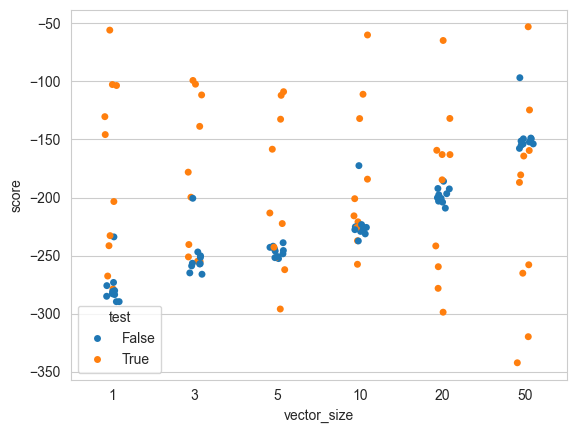

In [46]:
v_sizes = [1,3, 5,10, 20, 50]
all_scores = []
kfold = KFold(n_splits=10, shuffle=True)
for v_size in v_sizes:
    print(f"Vector size: {v_size}")
    for train_idx, test_idx in kfold.split(all_trajectories):
        train_trajectories = [all_trajectories[i] for i in train_idx]
        test_trajectories = [all_trajectories[i] for i in test_idx]
        e_logger = EpochLogger()
        model = Word2Vec(sentences=train_trajectories, vector_size=v_size, window=2, min_count=5, workers=4, callbacks=[e_logger], epochs=1000, hs=1, negative=0, compute_loss=True)
        test_score = model.score(test_trajectories)
        train_score = model.score(train_trajectories)
        all_scores.append({"vector_size": v_size, "score": test_score[0], "test": True})
        all_scores.append({"vector_size": v_size, "score": train_score[0], "test": False})
all_scores = pd.DataFrame(all_scores)
sns.stripplot(data=all_scores, x="vector_size", y="score", hue="test")
plt.show()

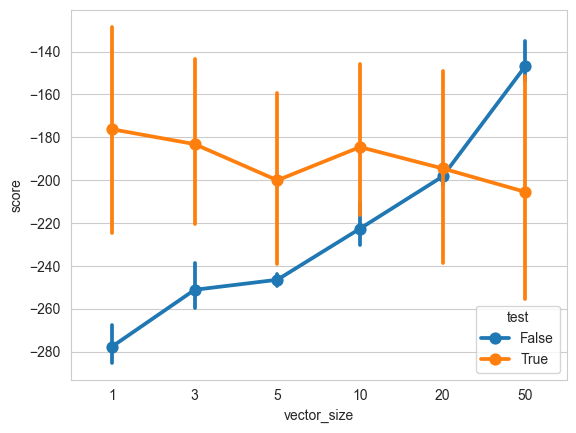

In [47]:
sns.pointplot(data=all_scores, x="vector_size", y="score", hue="test")
plt.show()

In [10]:
# fit final model with vector_size = 10
e_logger = EpochLogger()
model = Word2Vec(sentences=all_trajectories, vector_size=20, window=2, min_count=1, workers=4, callbacks=[e_logger], epochs=1000, hs=0, negative=100, compute_loss=True)
# get all embeddings
all_shapes = set([str(action[0]) for game in vanilla for action in game["actions"] if action[2] is not None])
all_shapes_embeddings = {shape: model.wv[shape] for shape in all_shapes}

# try to cluster the embeddings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

all_embeddings = np.array([all_shapes_embeddings[shape] for shape in all_shapes])
# silhouette_scores = []
# max_k = 30
# for n_clusters in tqdm.trange(2, max_k):
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(all_embeddings)
#     silhouette_scores.append(silhouette_score(all_embeddings, kmeans.labels_))
#
# plt.plot(np.arange(2, max_k), silhouette_scores, '-ok')
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Score")
# plt.show()

Loss after epoch 0: 189598.4375
Loss after epoch 1: 27983.09375
Loss after epoch 2: 20562.25
Loss after epoch 3: 17976.578125
Loss after epoch 4: 16533.828125
Loss after epoch 5: 15814.375
Loss after epoch 6: 15769.1875
Loss after epoch 7: 14445.03125
Loss after epoch 8: 15438.875
Loss after epoch 9: 15232.125
Loss after epoch 10: 15290.71875
Loss after epoch 11: 15322.375
Loss after epoch 12: 15466.0625
Loss after epoch 13: 15352.28125
Loss after epoch 14: 15484.4375
Loss after epoch 15: 15815.1875
Loss after epoch 16: 15658.21875
Loss after epoch 17: 16028.59375
Loss after epoch 18: 16268.40625
Loss after epoch 19: 15230.75
Loss after epoch 20: 16605.625
Loss after epoch 21: 15398.5625
Loss after epoch 22: 14332.9375
Loss after epoch 23: 15374.375
Loss after epoch 24: 15435.125
Loss after epoch 25: 15459.0625
Loss after epoch 26: 15827.5
Loss after epoch 27: 15230.3125
Loss after epoch 28: 16127.375
Loss after epoch 29: 15443.5
Loss after epoch 30: 15535.375
Loss after epoch 31: 1652

In [7]:
def get_shape_image(shape):
    REP_FACTOR = 8
    binary_mat = get_shape_binary_matrix(shape)
    binary_mat = np.repeat(binary_mat, REP_FACTOR, axis=0)
    binary_mat = np.repeat(binary_mat, REP_FACTOR, axis=1)
    binary_mat[np.arange(0, binary_mat.shape[0], REP_FACTOR), :] = 0
    binary_mat[:, np.arange(0, binary_mat.shape[1], REP_FACTOR)] = 0
    binary_mat[np.arange(REP_FACTOR-1, binary_mat.shape[0], REP_FACTOR), :] = 0
    binary_mat[:, np.arange(REP_FACTOR - 1, binary_mat.shape[1], REP_FACTOR)] = 0

    colors = np.array([[0,0,0], SHAOE_COLOR_RGB])
    img = colors[binary_mat.astype(int)]
    # get color for the frame based on cluster label
    return img


Shape 2699
Closest shapes:
2668: 0.964656412601471
2669: 0.8553272485733032
1378: 0.8451722264289856
8277: 0.8375891447067261
2872: 0.8144203424453735
Shape 17846
Closest shapes:
2345: 0.9258658289909363
26340: 0.8738037347793579
2383: 0.8576375842094421
20832: 0.8138975501060486
17859: 0.8018441796302795
Shape 423
Closest shapes:
28309: 0.836006224155426
236: 0.7951754927635193
8053: 0.7535024285316467
16549: 0.7392252683639526
85: 0.7157098650932312
Shape 1
Closest shapes:
9098: 0.7788687944412231
236: 0.7296361327171326
179: 0.7215774655342102
22911: 0.6976490020751953
4747: 0.6947885155677795
Shape 1291
Closest shapes:
8891: 0.8515135049819946
1435: 0.775975227355957
4580: 0.733769416809082
1112: 0.727059006690979
13216: 0.7213624119758606
Shape 2668
Closest shapes:
2699: 0.964656412601471
2669: 0.868474543094635
2872: 0.8240980505943298
1378: 0.8098419308662415
8277: 0.7886822819709778
Shape 5210
Closest shapes:
14534: 0.8441821932792664
1448: 0.8046015501022339
14492: 0.792034745

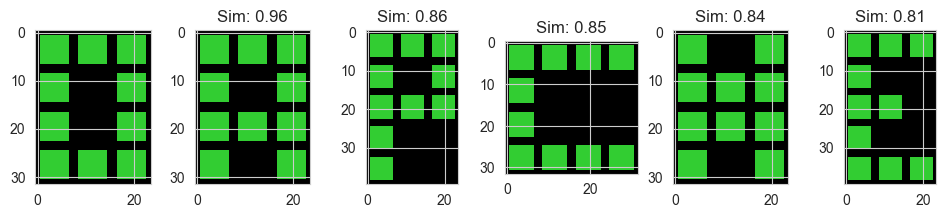

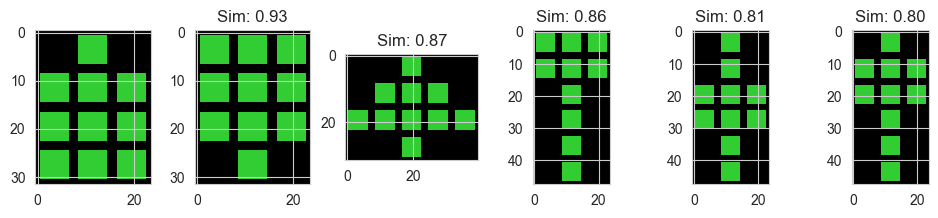

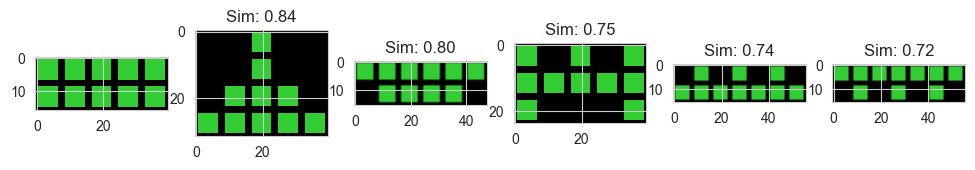

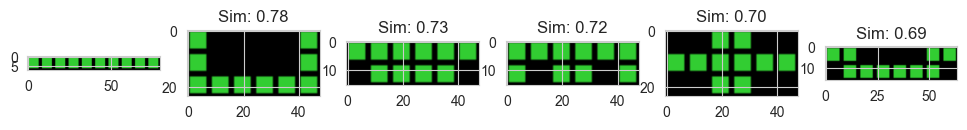

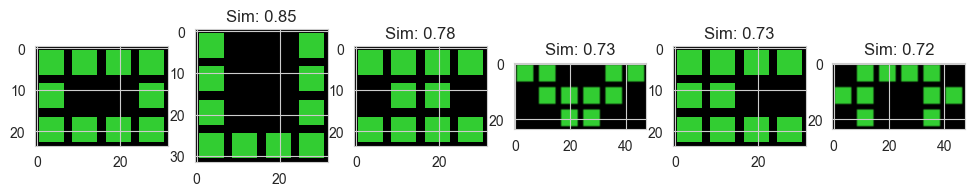

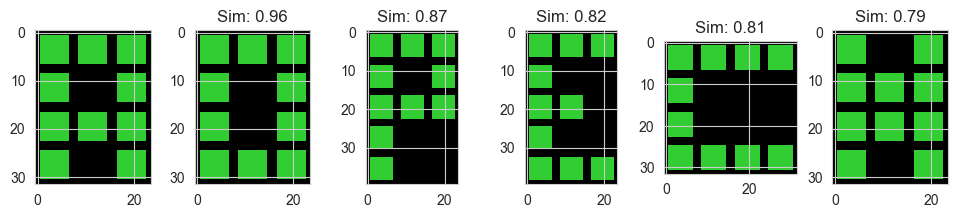

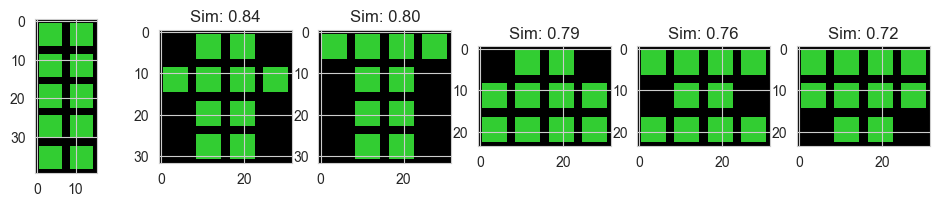

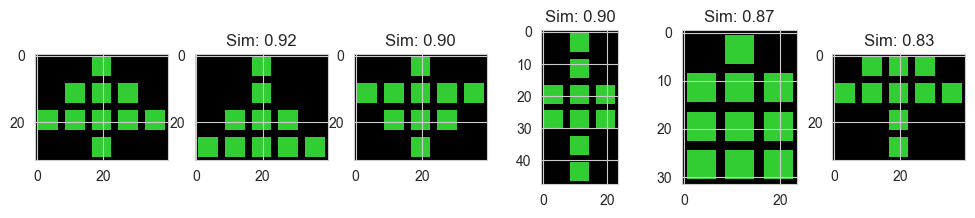

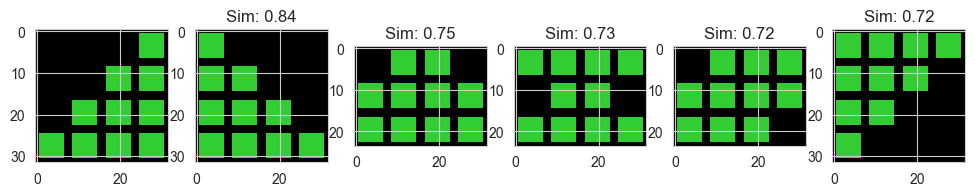

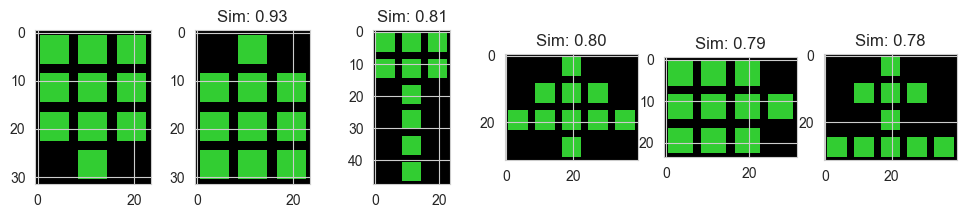

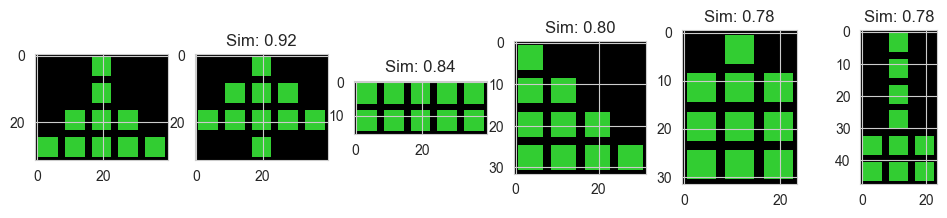

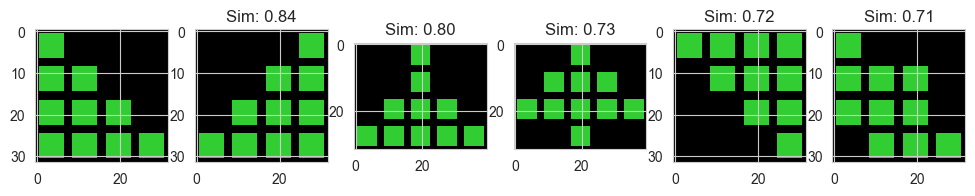

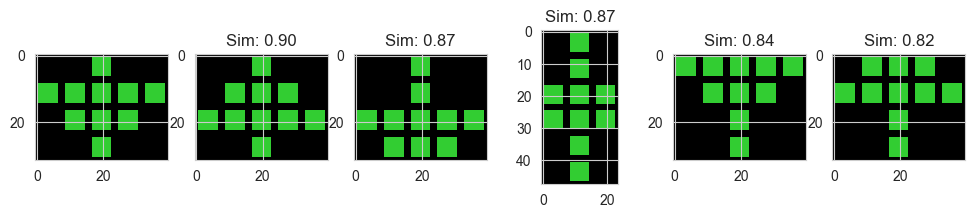

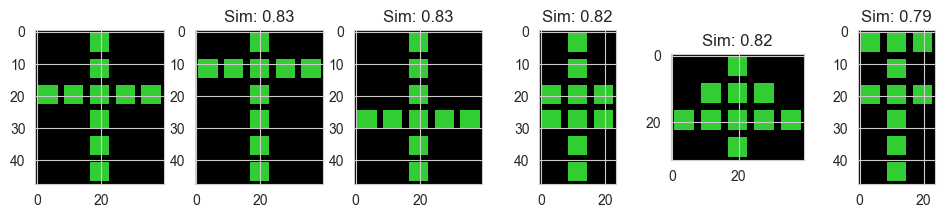

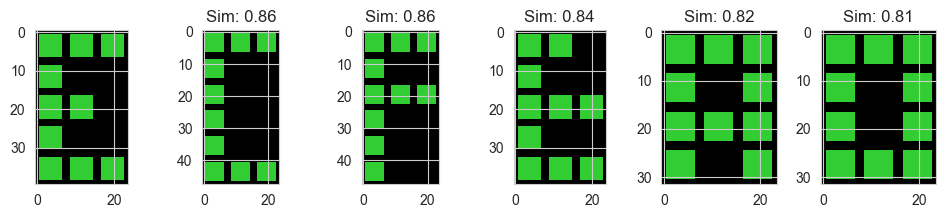

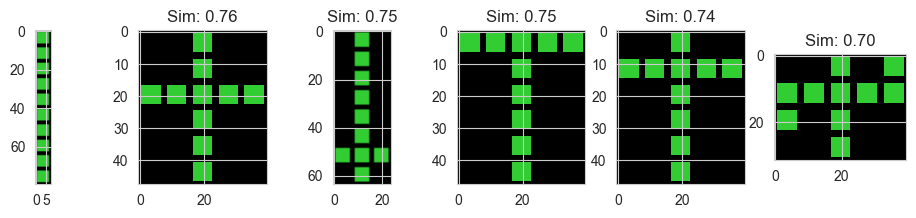

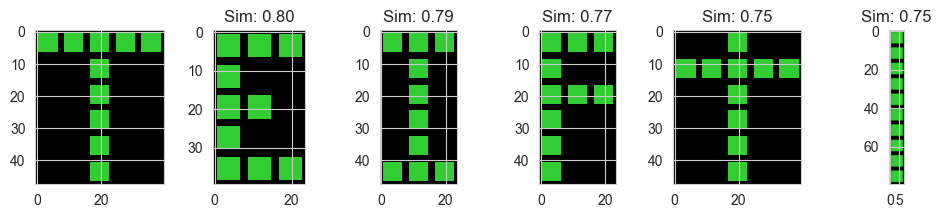

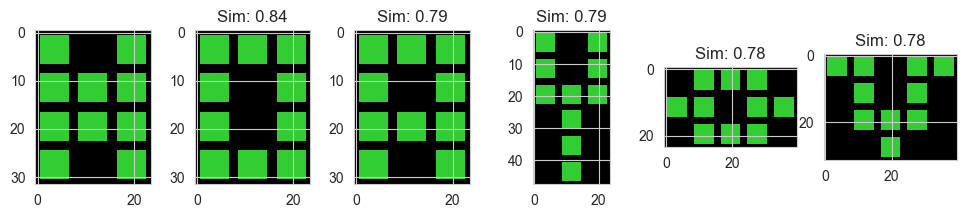

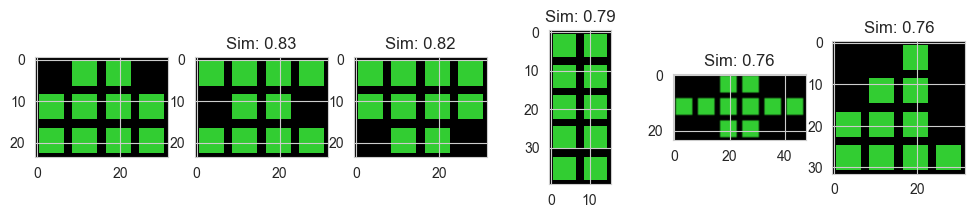

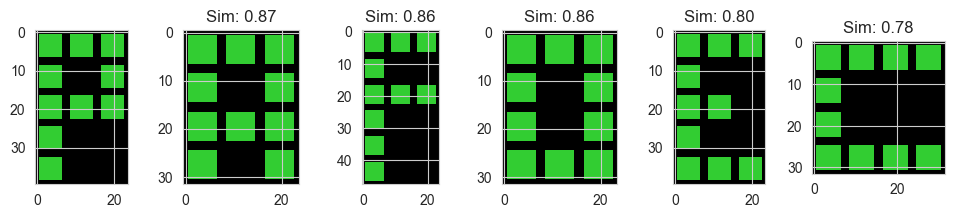

In [11]:
# get the top 20 shapes with the highest count and for each of them plot the 5 closest shapes:
from collections import Counter
counter = Counter([shape for traj in all_trajectories for shape in traj])
top_shapes = [shape for shape, count in counter.most_common(20)]

for shape in top_shapes:
    print(f"Shape {shape}")
    fig, axes = plt.subplots(1, 6, figsize=(12, 2))
    shape_img = get_shape_image(int(shape))
    plt.sca(axes[0])
    plt.imshow(shape_img)
    print(f"Closest shapes:")
    for (close_shape, sim), ax in zip(model.wv.most_similar(shape, topn=5), axes[1:]):
        print(f"{close_shape}: {sim}")
        close_shape_img = get_shape_image(int(close_shape))
        plt.sca(ax)
        plt.imshow(close_shape_img)
        plt.title(f"Sim: {sim:.2f}")
    plt.savefig(f"top_shapes_nns_{shape}.png")

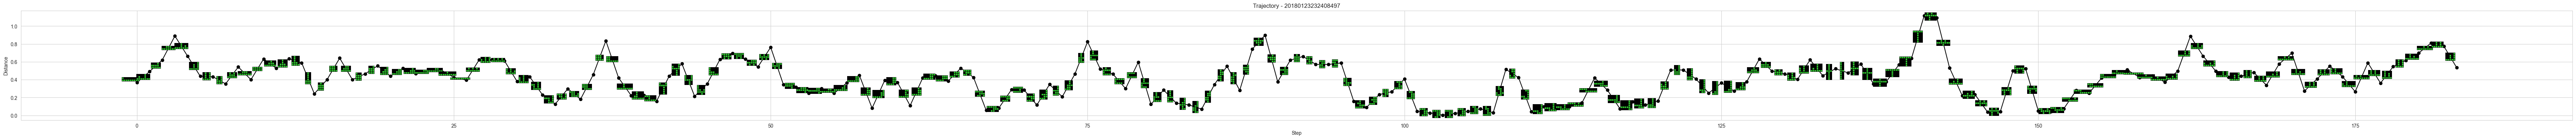

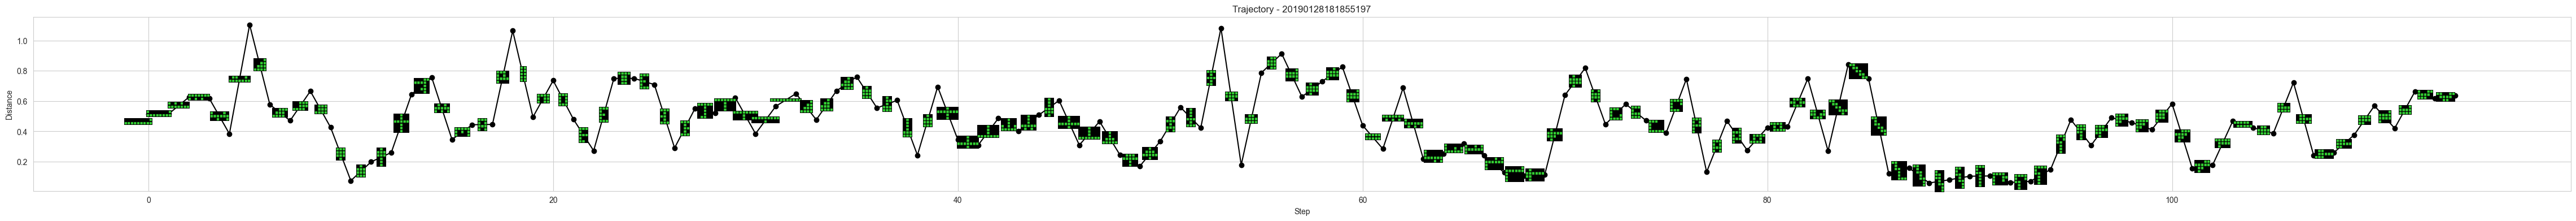

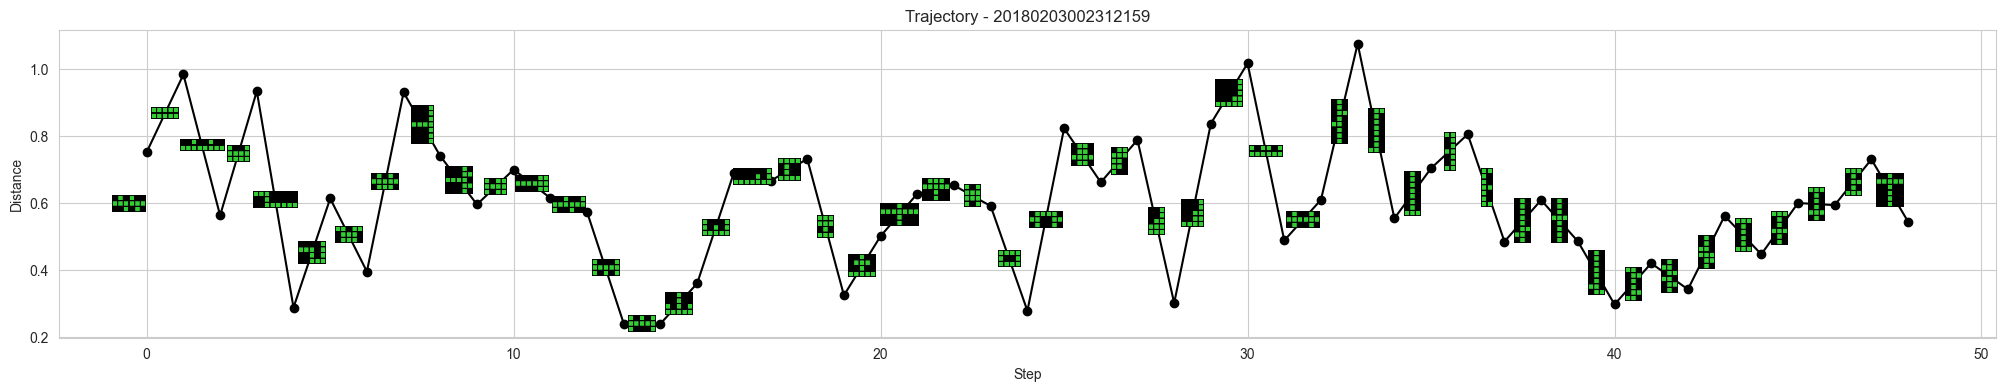

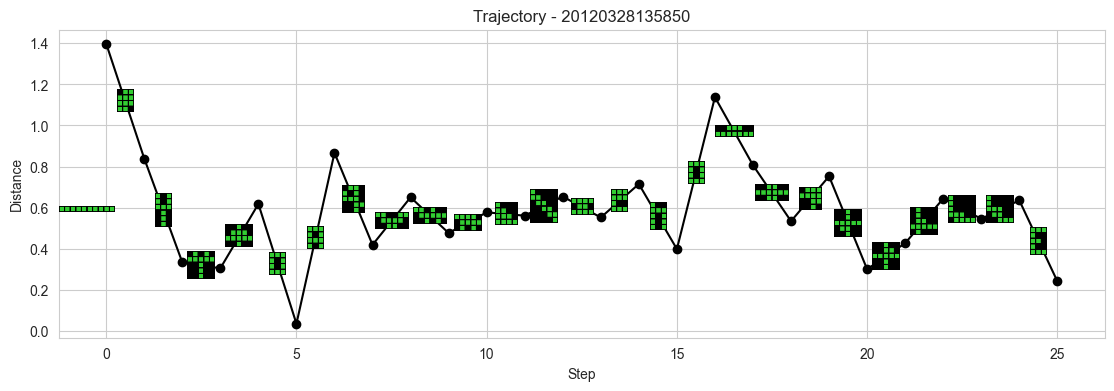

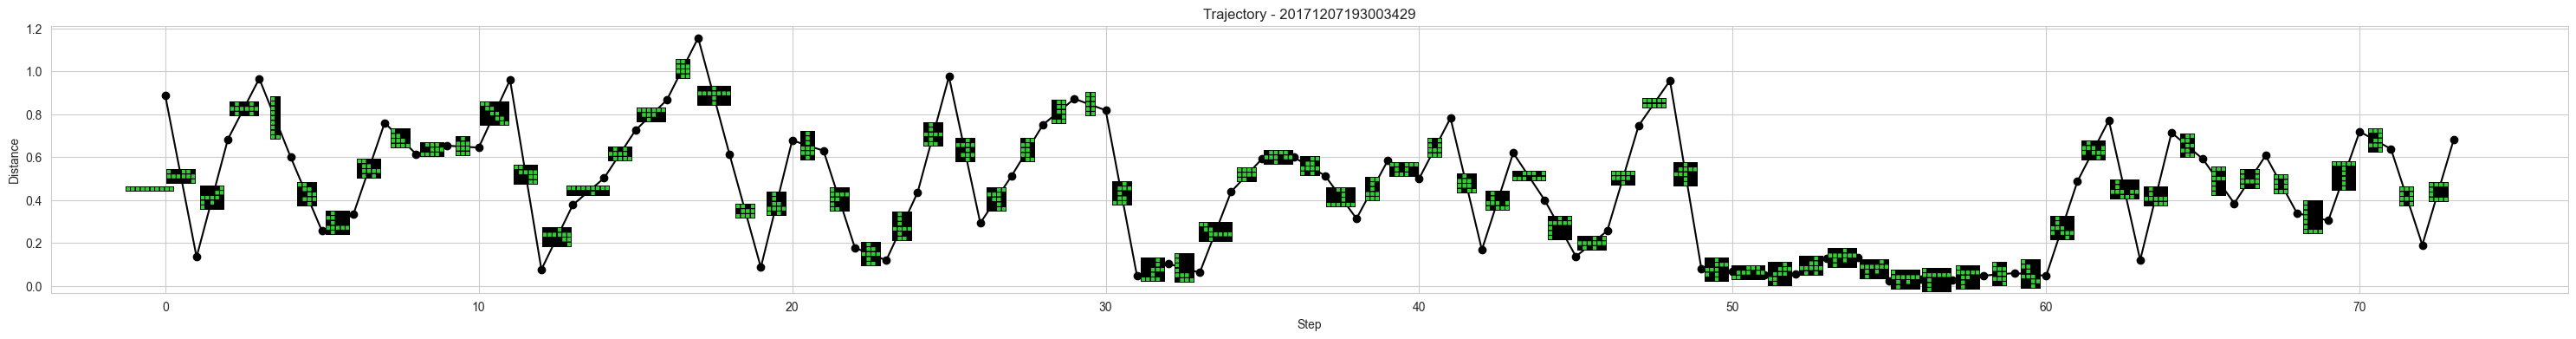

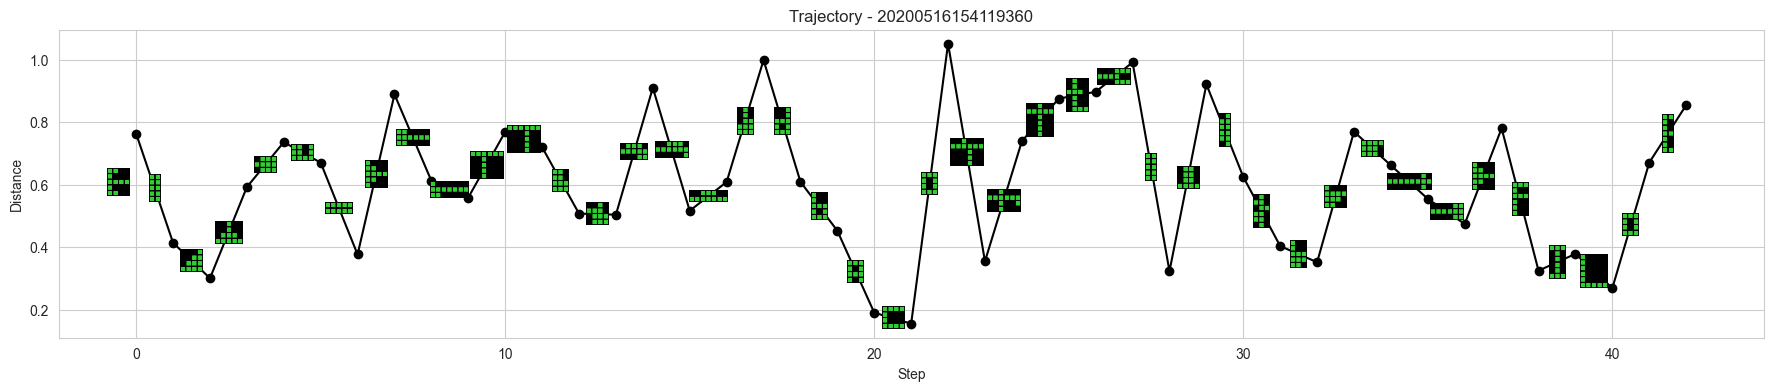

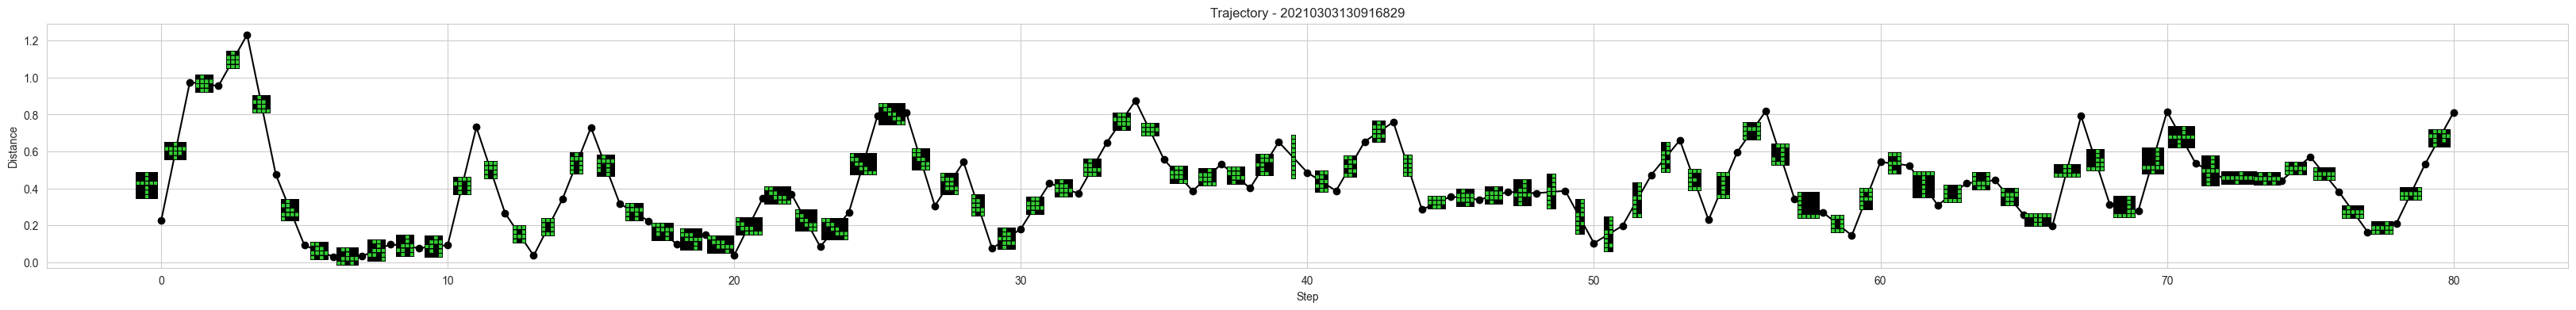

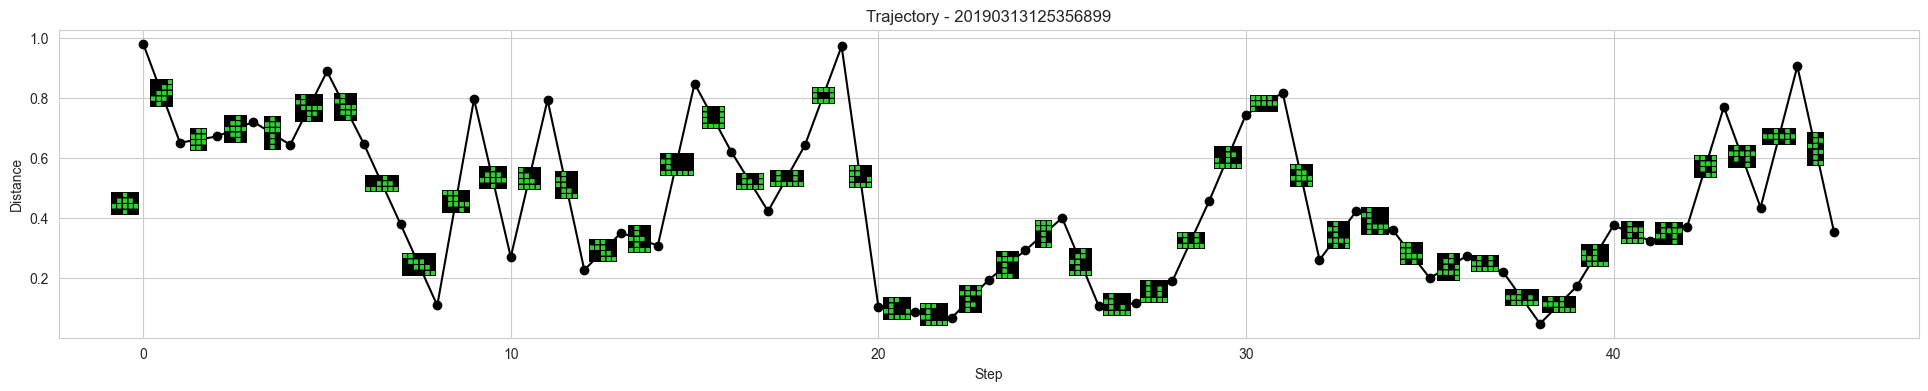

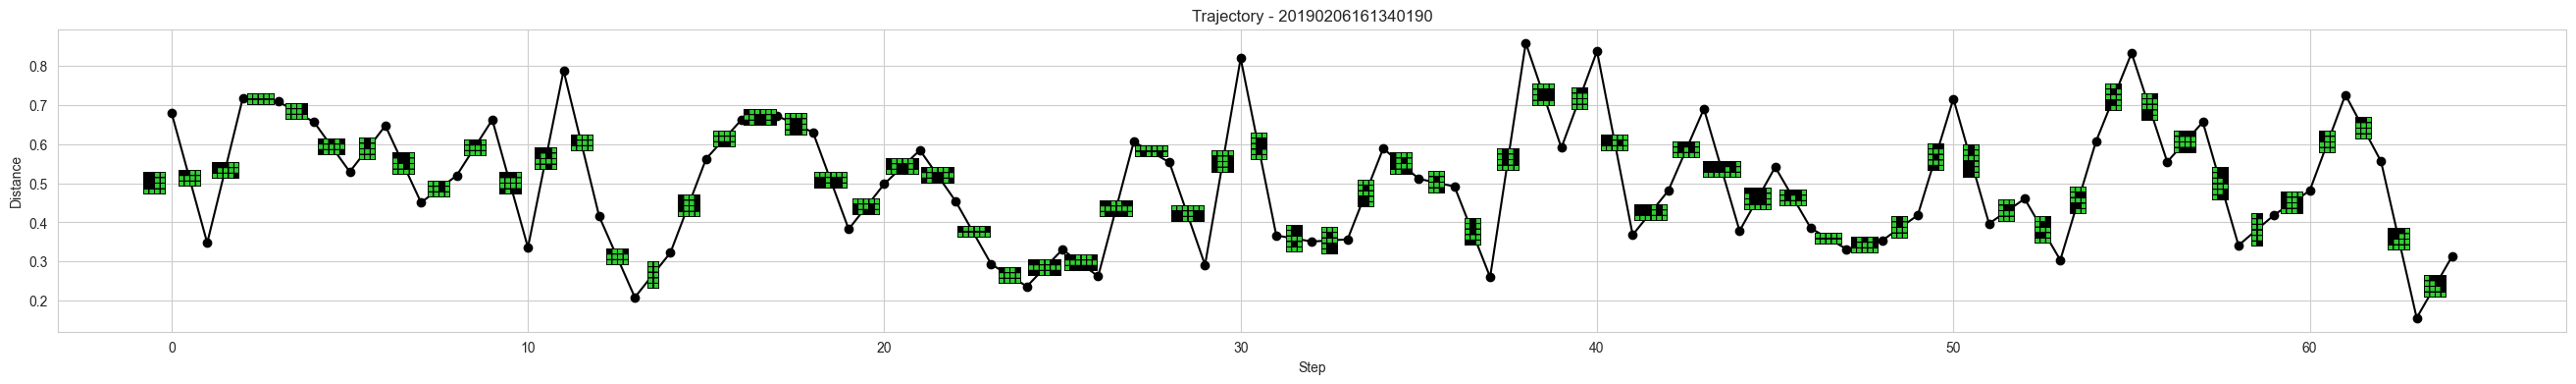

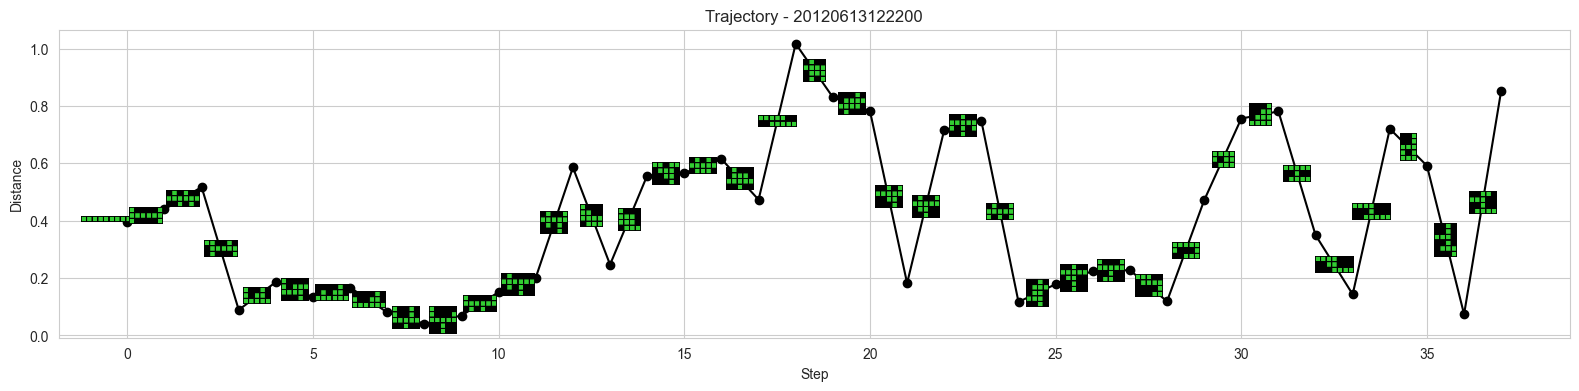

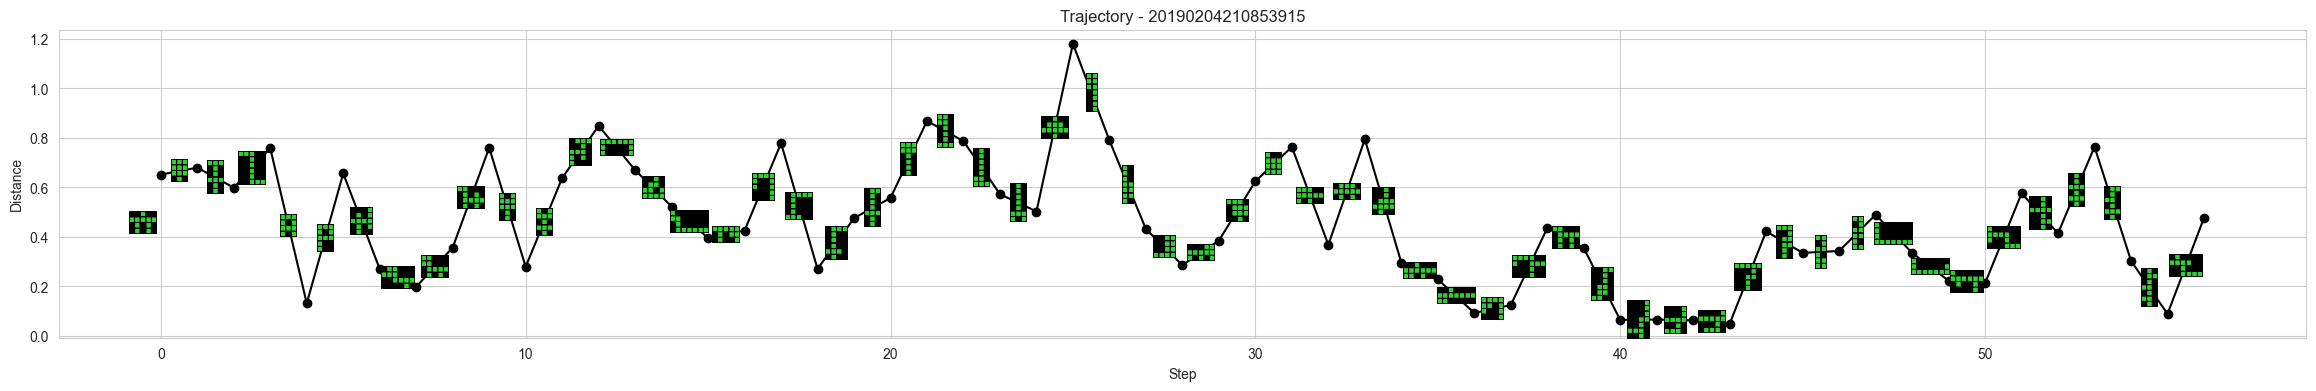

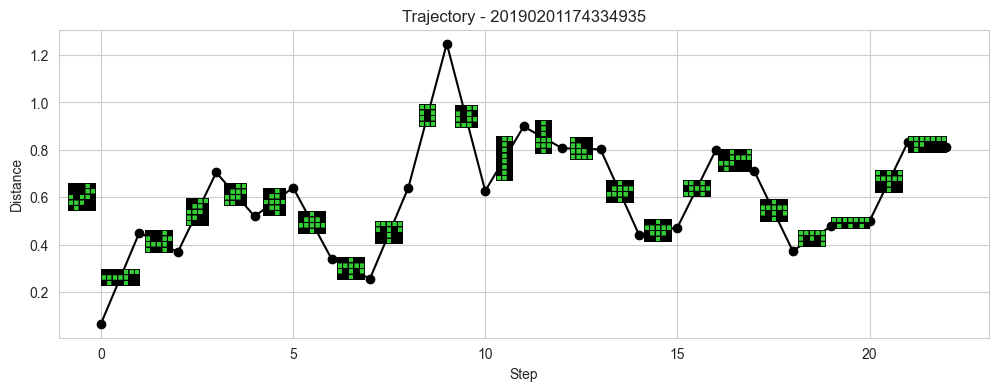

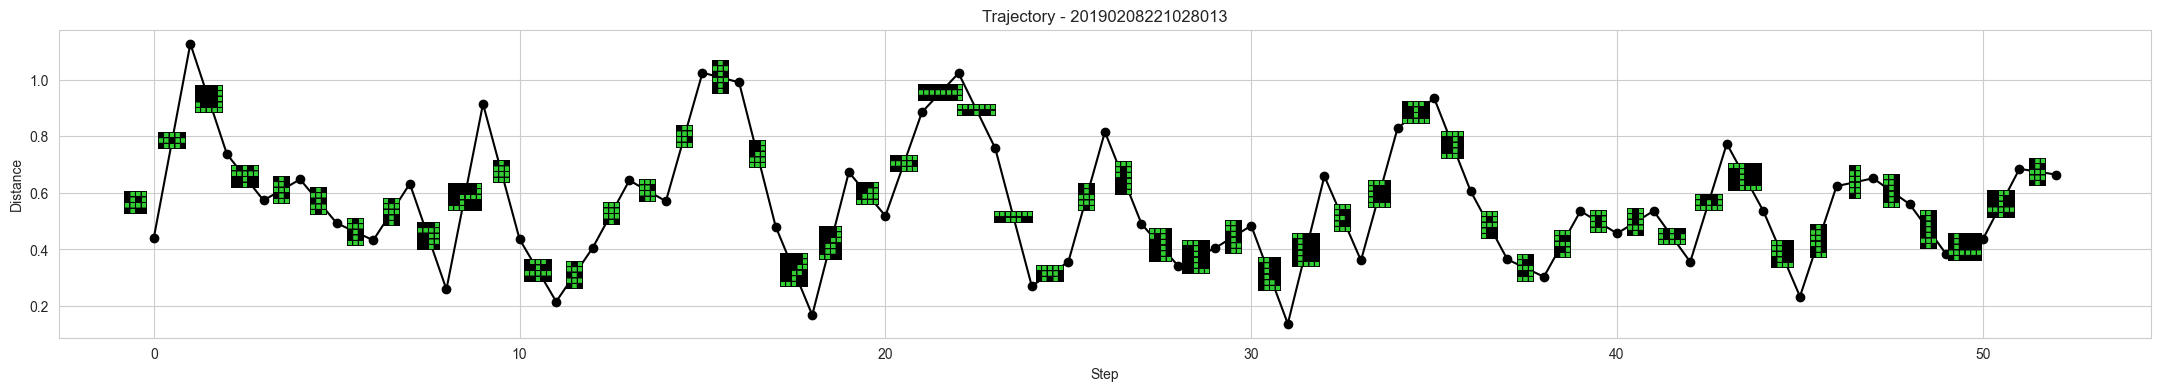

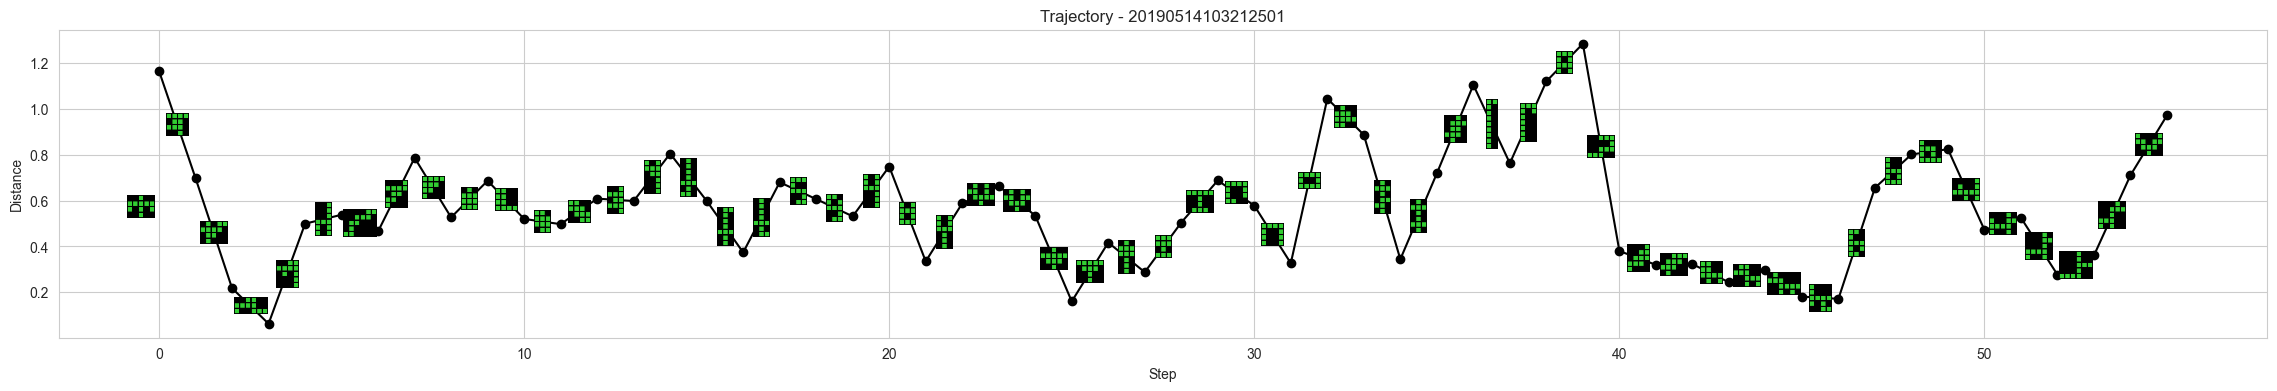

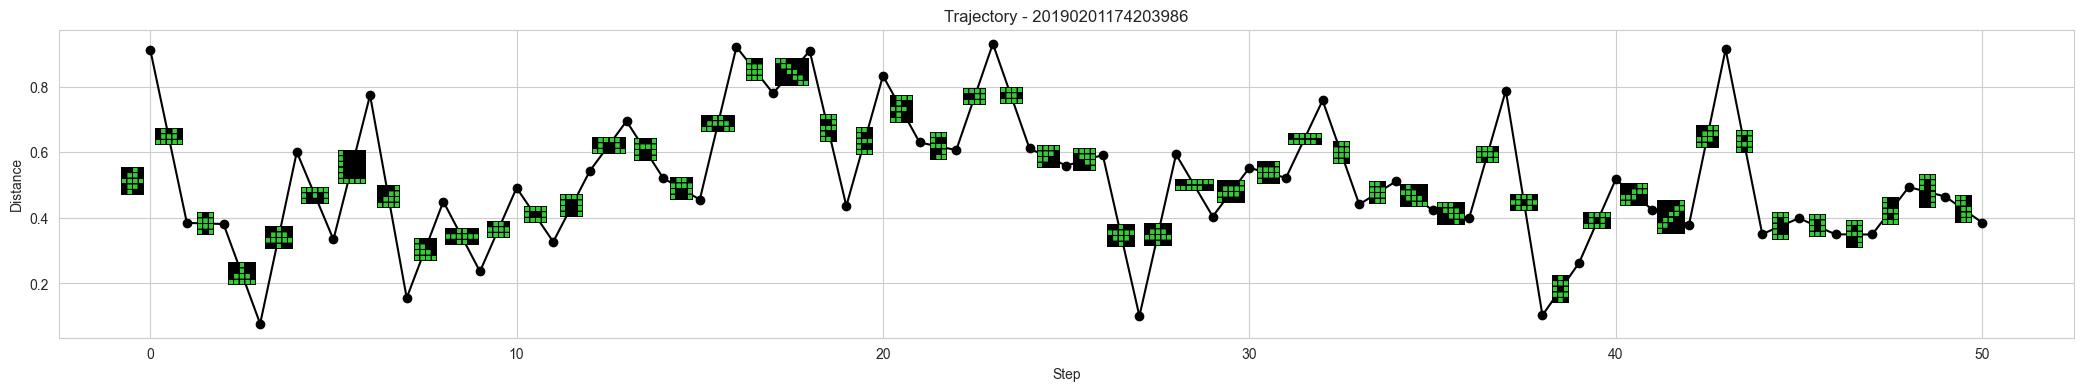

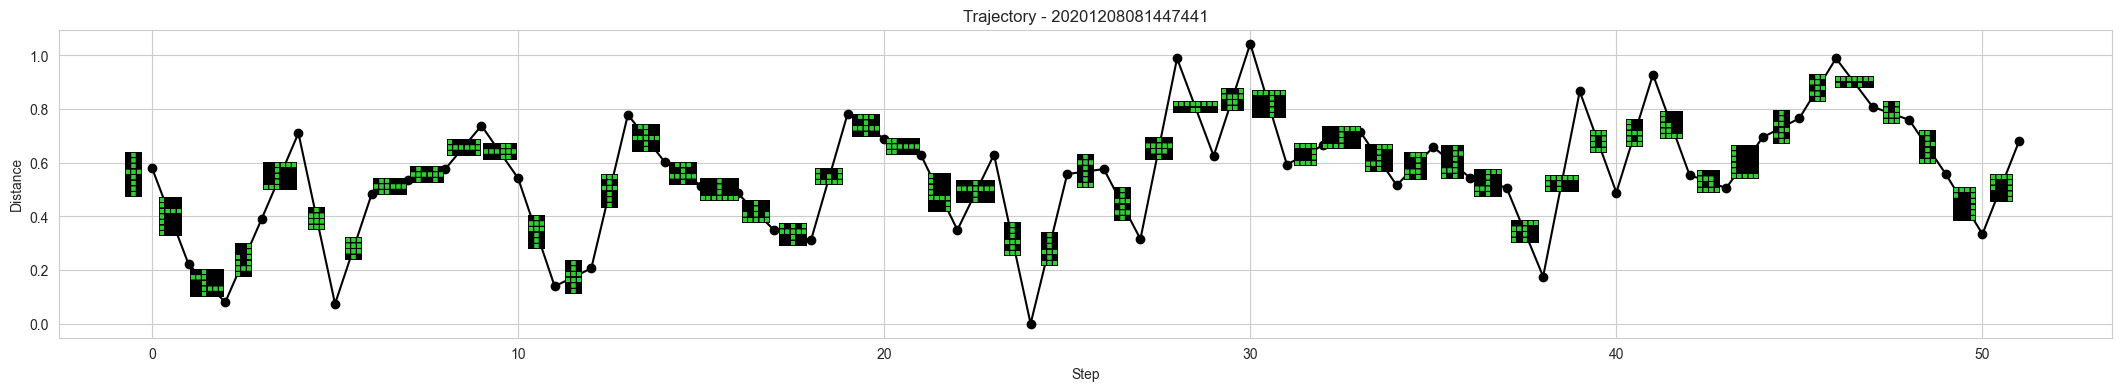

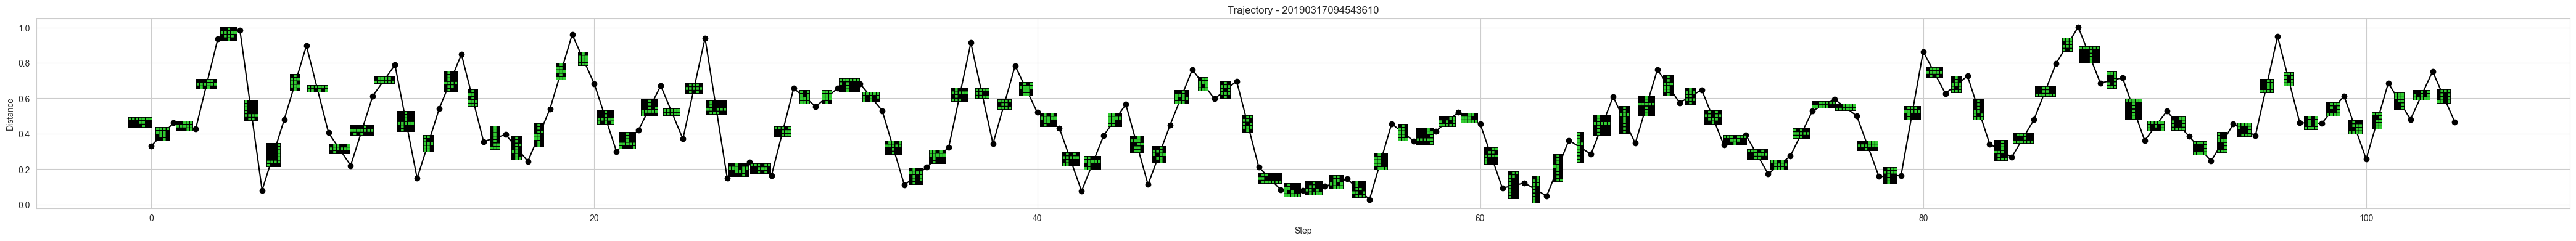

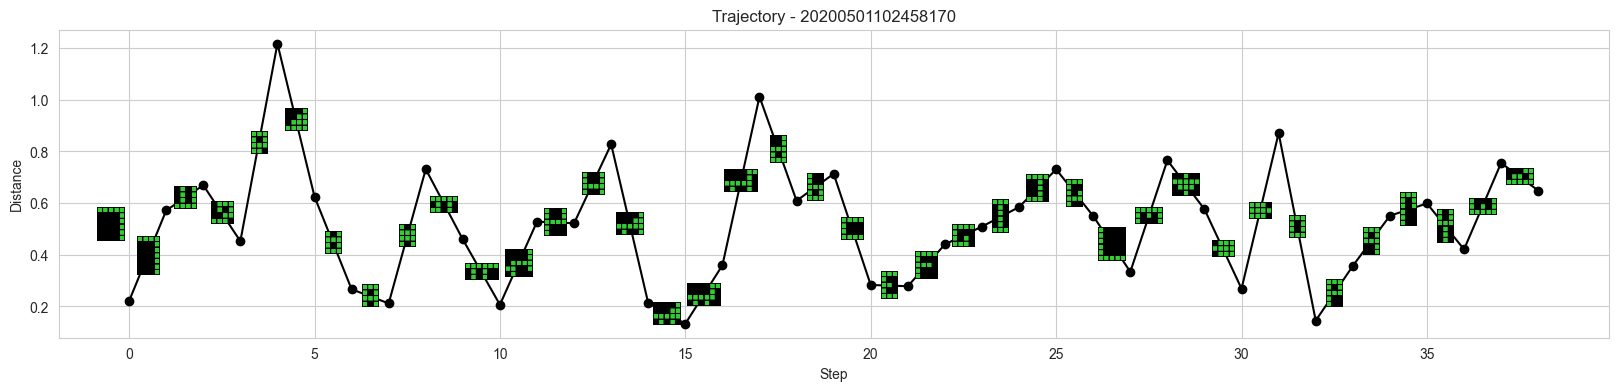

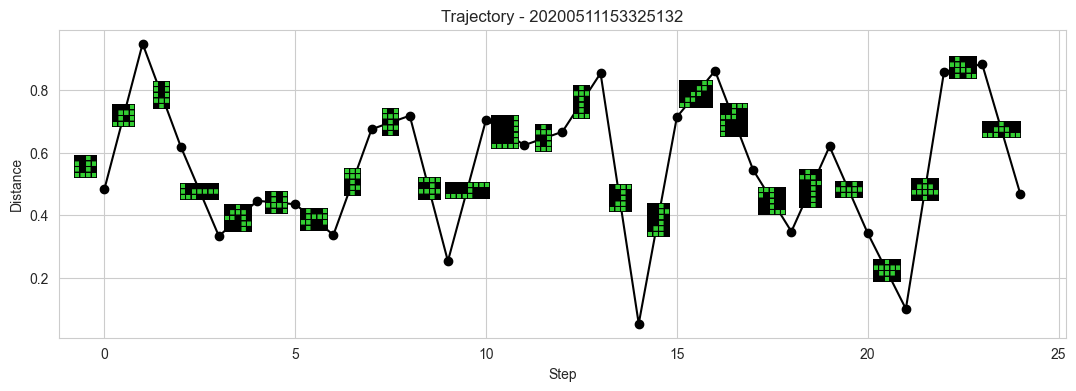

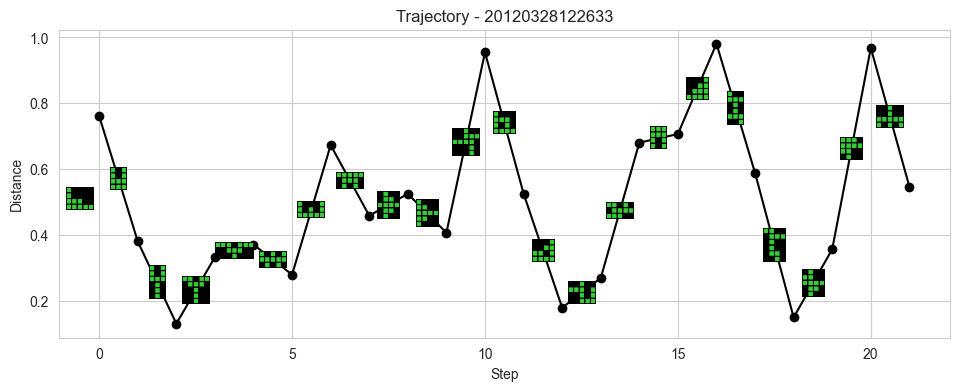

In [12]:
# go over random trajectories and plot the pairwise embedding distance between consecutive shapes:
from sklearn.metrics.pairwise import paired_cosine_distances
np.random.seed(1)
for i in range(20):
    rand_idx = np.random.randint(len(all_trajectories))
    traj = all_trajectories[rand_idx]
    plt.figure(figsize=(len(traj) / 2,4))
    traj_embeddings = np.array([all_shapes_embeddings[shape] for shape in traj])
    distances = paired_cosine_distances(traj_embeddings[:-1], traj_embeddings[1:])
    plt.plot(np.arange(len(distances)), distances, '-ok')
    # annotate points with shape images:
    for idx, shape in enumerate(traj[:-1]):
        img = get_shape_image(int(shape))
        imagebox = OffsetImage(img, zoom=0.5)
        y = (distances[idx] + distances[idx-1]) / 2 if idx > 0 else np.mean(distances)
        ab = AnnotationBbox(imagebox, (idx - 0.5, y), frameon=False)
        plt.gca().add_artist(ab)
    plt.xlabel("Step")
    plt.ylabel("Distance")
    plt.title(f"Trajectory - {vanilla[rand_idx]['id']}")
    plt.savefig(f"trajectory_{i}.png")

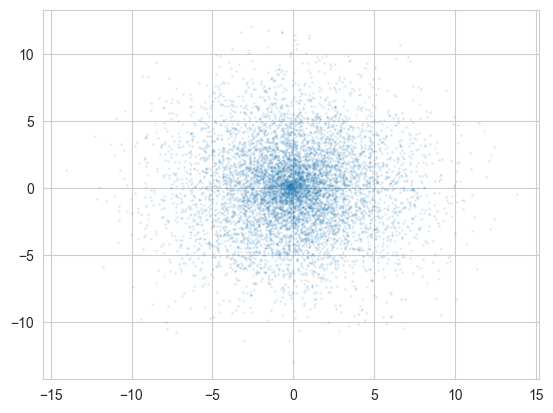

In [50]:
pca = PCA(n_components=2)
all_embeddings_proj = pca.fit_transform(all_embeddings)
plt.scatter(all_embeddings_proj[:, 0], all_embeddings_proj[:, 1], s=1, alpha=0.1)
plt.show()

In [50]:
DIRECTIONAL = False
COUNT_THRESHOLD = 3
with open("vanilla.json") as vanilla_fp:
    vanilla = json.load(vanilla_fp)
all_gallery_transitions = []
all_counts = {}
all_gallery_shapes = set()
for game in tqdm.tqdm(vanilla):
    pre_shape = None
    for action in game["actions"]:
        if action[2] is not None:
            all_gallery_shapes.add(action[0])
            if action[0] in all_counts:
                all_counts[action[0]] += 1
            else:
                all_counts[action[0]] = 1
            if pre_shape is not None:
                all_gallery_transitions.append((pre_shape, action[0]))
            pre_shape = action[0]

all_gallery_shapes = [k for k,v in all_counts.items() if v > COUNT_THRESHOLD]
shape2idx = {shape: idx for idx, shape in enumerate(all_gallery_shapes)}
other_shapes = list(set(all_counts.keys()) - set(all_gallery_shapes))
shape2idx.update({shape: idx for idx, shape in enumerate(other_shapes, len(all_gallery_shapes))})
idx2shape = {idx: shape for shape, idx in shape2idx.items()}
n_shapes_pruned = len(all_gallery_shapes)
n_shapes_total = len(shape2idx)
transition_matrix = np.zeros((n_shapes_pruned, n_shapes_total))
for pre_shape, post_shape in tqdm.tqdm(all_gallery_transitions):
    if (pre_shape in all_gallery_shapes):
        transition_matrix[shape2idx[pre_shape], shape2idx[post_shape]] += 1
    if (not DIRECTIONAL) and (post_shape in all_gallery_shapes):
        transition_matrix[shape2idx[post_shape], shape2idx[pre_shape]] += 1

100%|██████████| 29040/29040 [00:00<00:00, 49276.96it/s]


In [51]:
transition_matrix.shape

(1190, 7854)

In [52]:
from sklearn.metrics import explained_variance_score
MAX_DIM = 30
errors = []
explained_variance = []
pca_explained_variance = []
for n_components in tqdm.trange(1, MAX_DIM):
    nmf = NMF(n_components=n_components)
    nmf.fit(transition_matrix)
    errors.append(nmf.reconstruction_err_)
    # explained_variance.append(1 - nmf.reconstruction_err_ / np.sum((transition_matrix - transition_matrix.mean(axis=0, keepdims=True))**2))
    explained_variance.append(explained_variance_score(transition_matrix, nmf.inverse_transform(nmf.transform(transition_matrix))))
    pca = PCA(n_components=n_components)
    pca.fit(transition_matrix)
    pca_explained_variance.append(explained_variance_score(transition_matrix, pca.inverse_transform(pca.transform(transition_matrix))))

 28%|██▊       | 8/29 [00:19<00:56,  2.67s/it]/Users/danamir/envs/pareto-control/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
 55%|█████▌    | 16/29 [00:37<00:26,  2.02s/it]/Users/danamir/envs/pareto-control/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 29/29 [01:22<00:00,  2.84s/it]


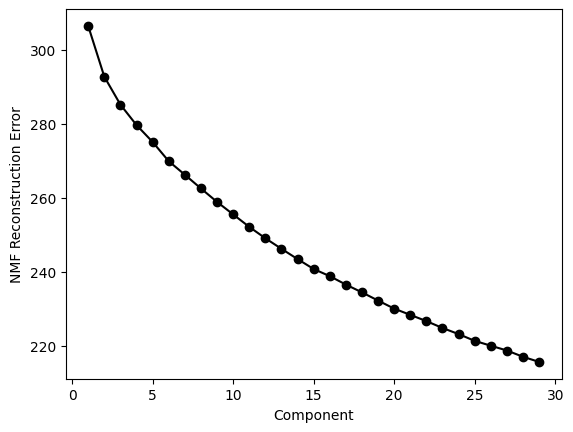

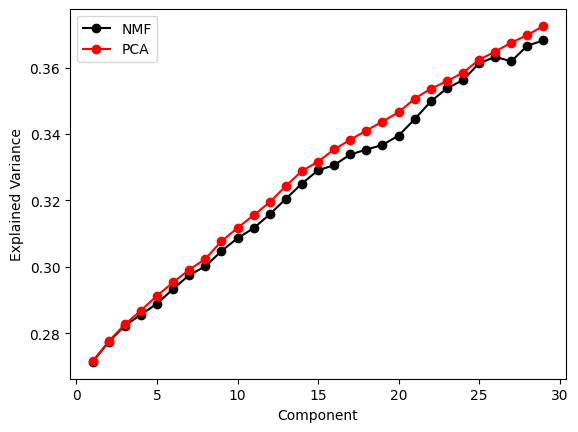

In [53]:
plt.plot(np.arange(1, MAX_DIM), errors, '-ok')
plt.xlabel("Component")
plt.ylabel("NMF Reconstruction Error")
plt.show()
plt.plot(np.arange(1, MAX_DIM), explained_variance, '-ok', label='NMF')
plt.plot(np.arange(1, MAX_DIM), pca_explained_variance, '-or', label='PCA')
plt.xlabel("Component")
plt.ylabel("Explained Variance")
# plt.loglog()
plt.legend()
plt.show()

In [40]:
def get_shape_image(shape):
    REP_FACTOR = 8
    binary_mat = get_shape_binary_matrix(shape)
    binary_mat = np.repeat(binary_mat, REP_FACTOR, axis=0)
    binary_mat = np.repeat(binary_mat, REP_FACTOR, axis=1)
    binary_mat[np.arange(0, binary_mat.shape[0], REP_FACTOR), :] = 0
    binary_mat[:, np.arange(0, binary_mat.shape[1], REP_FACTOR)] = 0
    binary_mat[np.arange(REP_FACTOR-1, binary_mat.shape[0], REP_FACTOR), :] = 0
    binary_mat[:, np.arange(REP_FACTOR - 1, binary_mat.shape[1], REP_FACTOR)] = 0

    colors = np.array([[0,0,0], SHAOE_COLOR_RGB])
    img = colors[binary_mat.astype(int)]
    # get color for the frame based on cluster label
    return img


In [55]:
nmf = NMF(n_components=20)
nmf.fit(transition_matrix)

NMF(n_components=20)

In [56]:
transitions_projected = nmf.transform(transition_matrix)


100%|██████████| 28/28 [00:00<00:00, 31.14it/s]


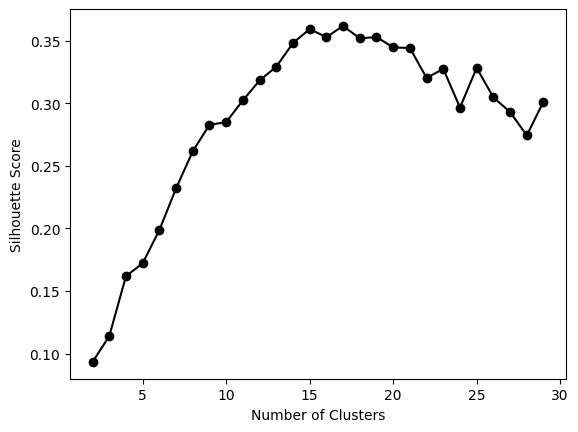

In [57]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
transitions_projected_normed = transitions_projected / np.linalg.norm(transitions_projected, axis=1, keepdims=True)
silhouette_scores = []
max_k = 30
for n_clusters in tqdm.trange(2, max_k):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(transitions_projected_normed)
    silhouette_scores.append(silhouette_score(transitions_projected_normed, kmeans.labels_))

plt.plot(np.arange(2, max_k), silhouette_scores, '-ok')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [60]:
transition_matrix

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  2., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(1190, 7854))

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
Cluster 7
Cluster 8
Cluster 9
Cluster 10
Cluster 11
Cluster 12
Cluster 13
Cluster 14
Cluster 15
Cluster 16


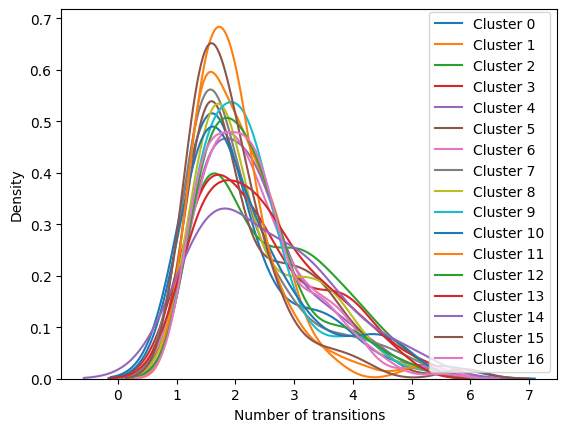

In [61]:
best_k = np.argmax(silhouette_scores) + 2
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(transitions_projected / np.linalg.norm(transitions_projected, axis=1, keepdims=True))
for c_index in range(best_k):
    print(f"Cluster {c_index}")
    counts = transition_matrix[kmeans.labels_ == c_index].sum(axis=1) / 2
    # plot  kde of the counts distribution
    sns.kdeplot(np.log(counts), label=f"Cluster {c_index}")
plt.xlabel("Number of transitions")
plt.ylabel("Density")
plt.legend()
plt.show()

<Axes: xlabel='cluster', ylabel='count'>

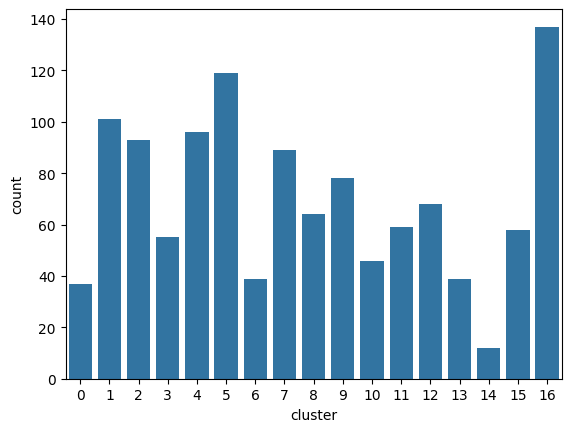

In [65]:
import pandas as pd
df = pd.DataFrame({"cluster": kmeans.labels_})
sns.countplot(df, x="cluster")

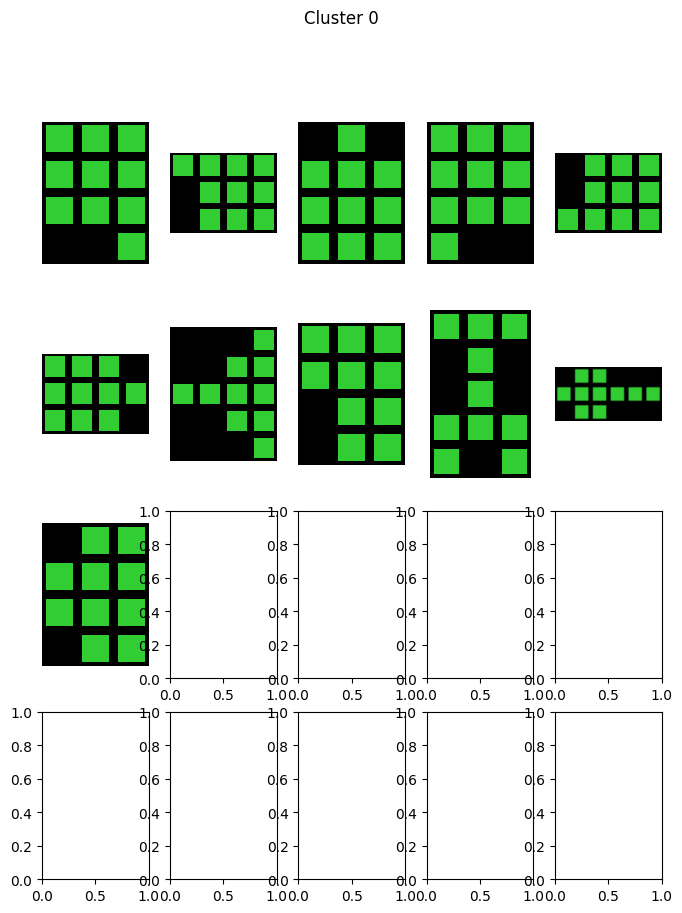

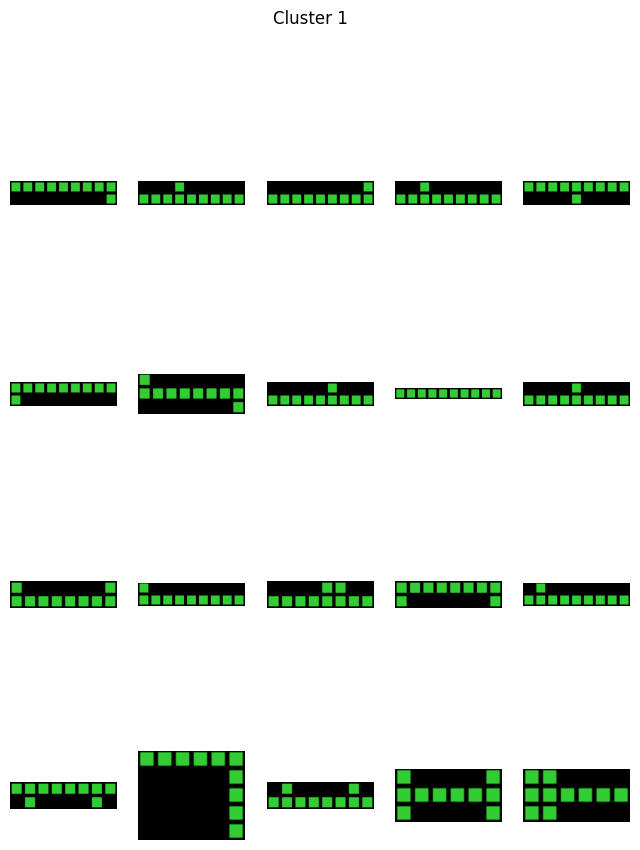

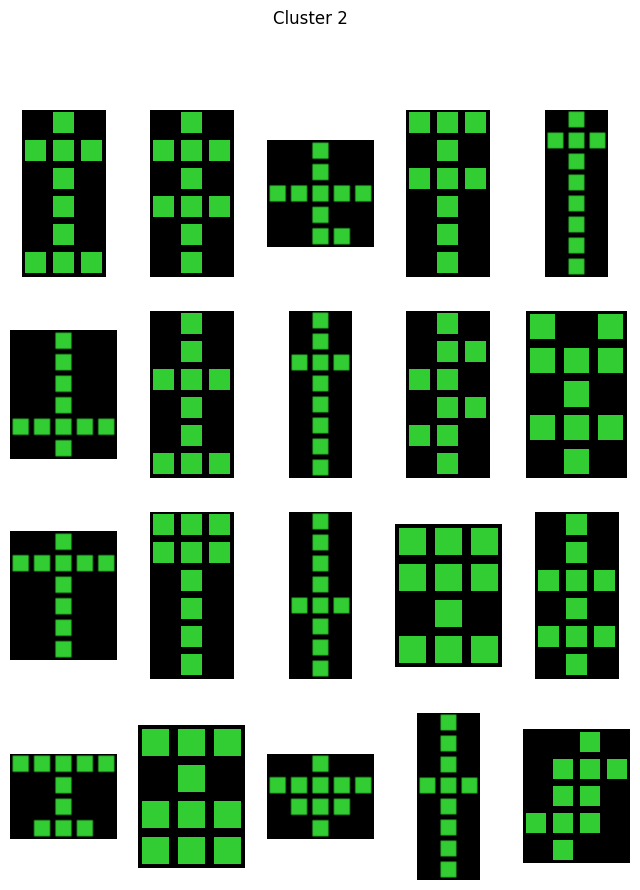

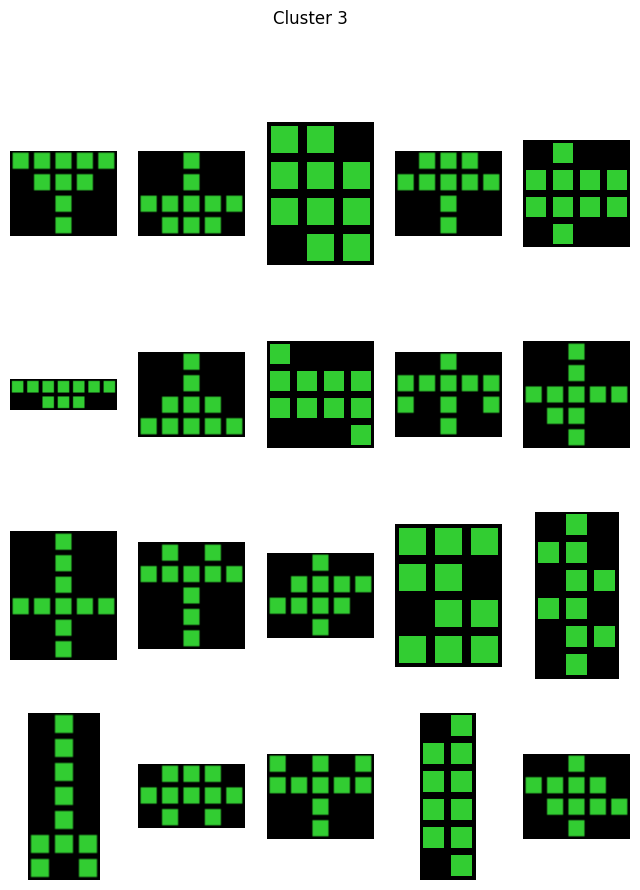

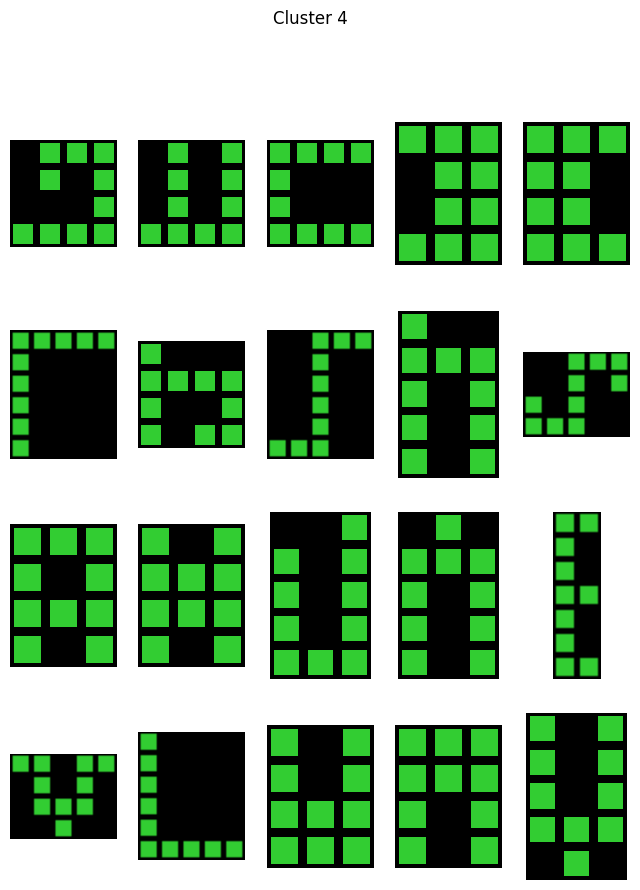

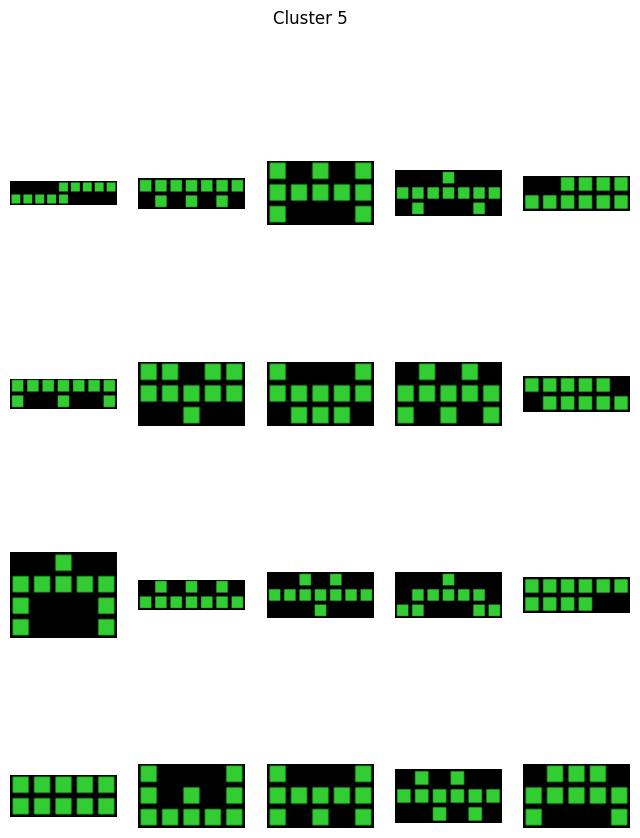

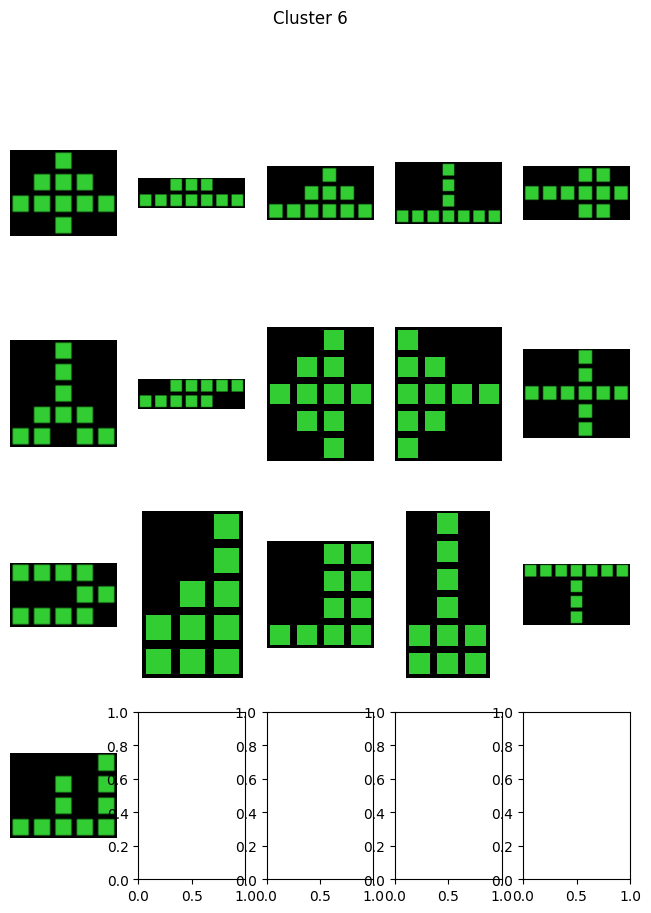

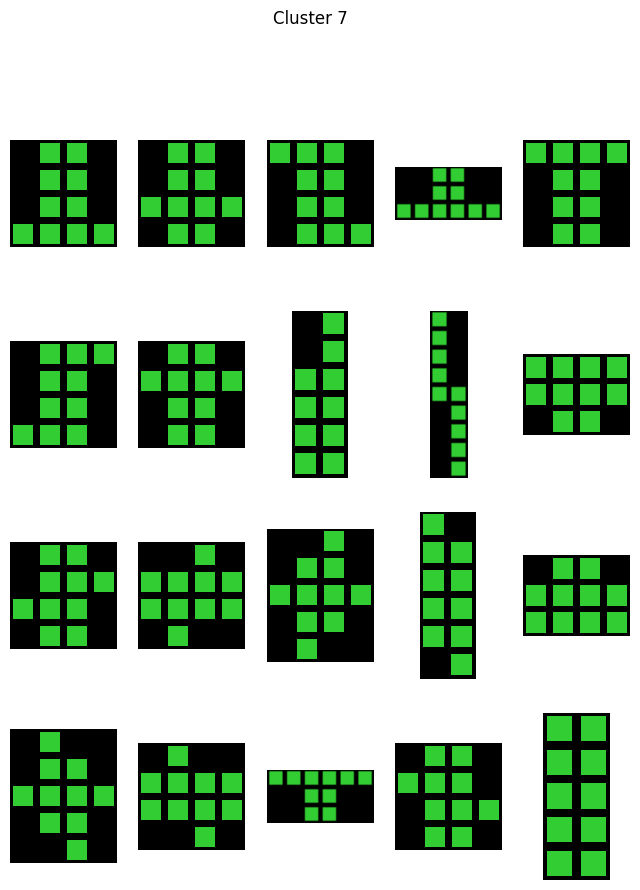

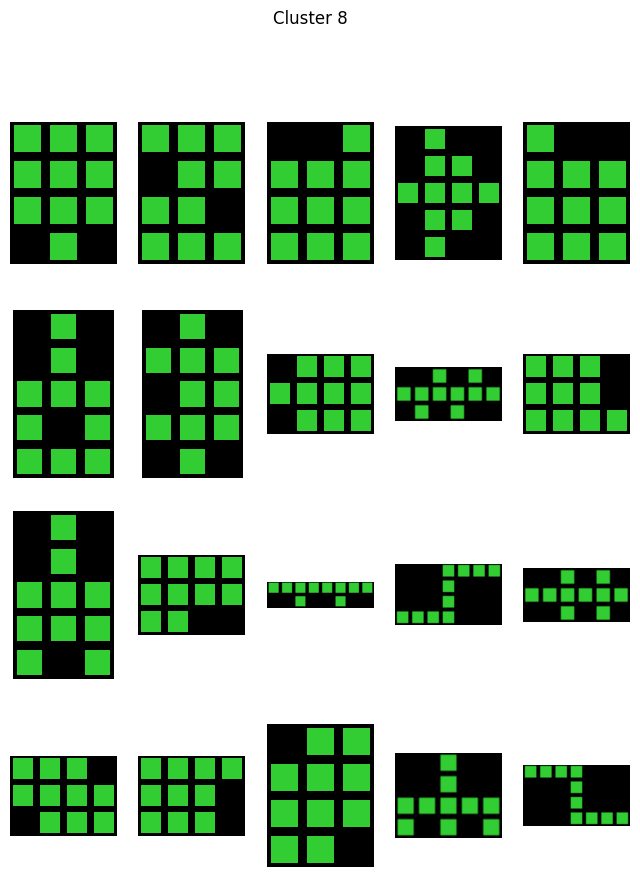

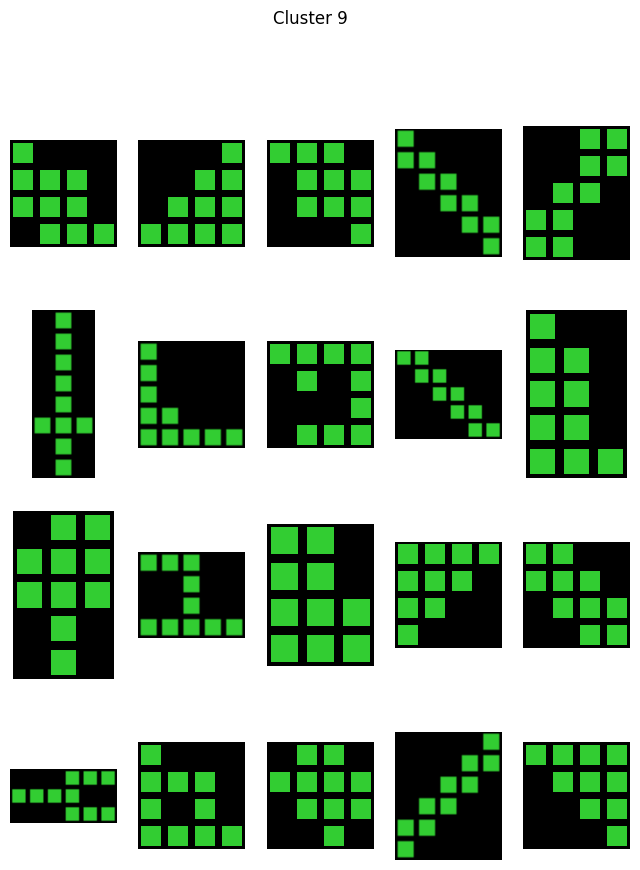

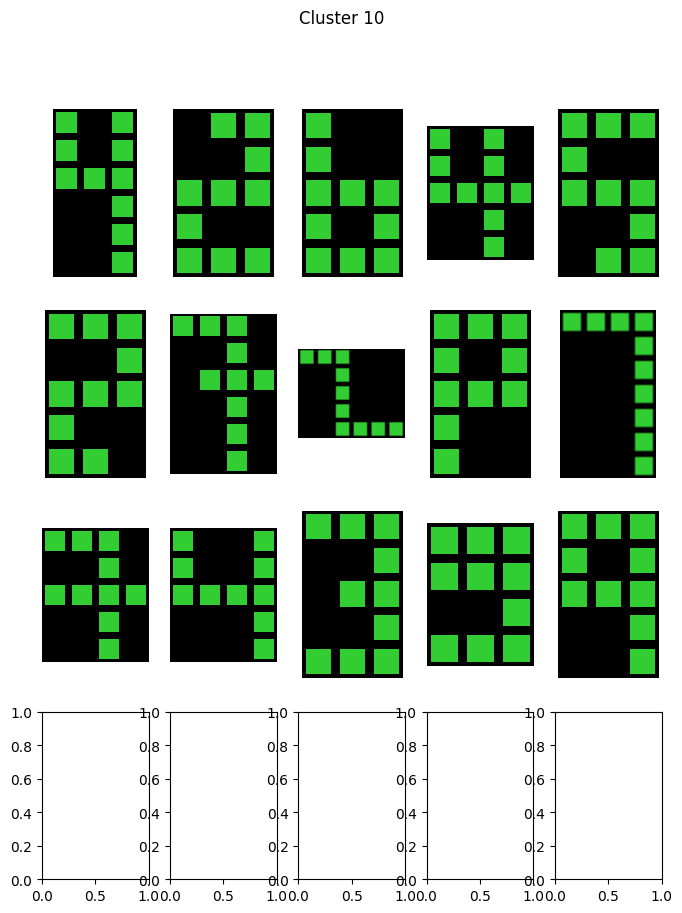

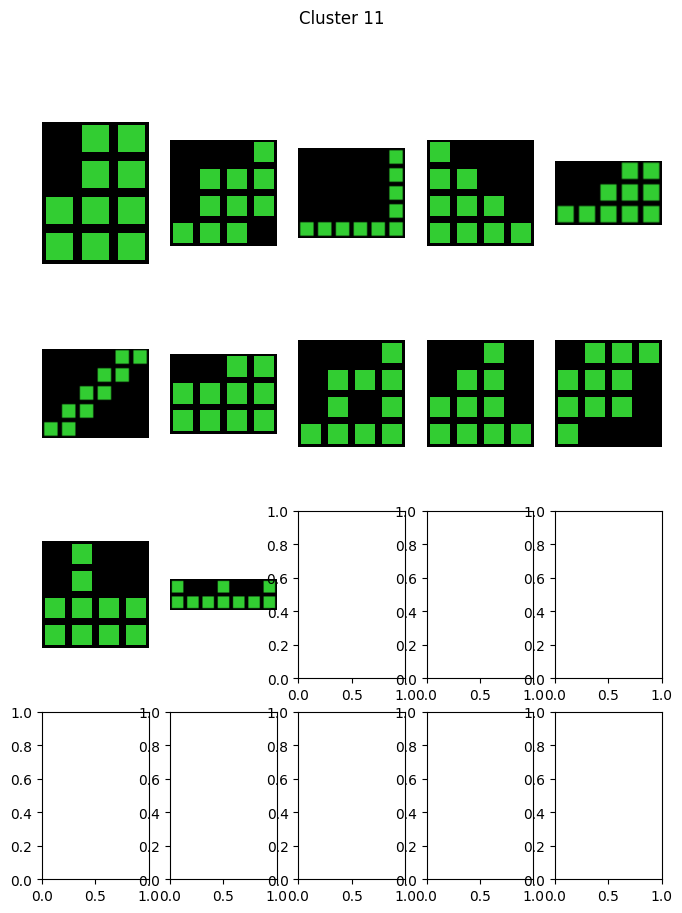

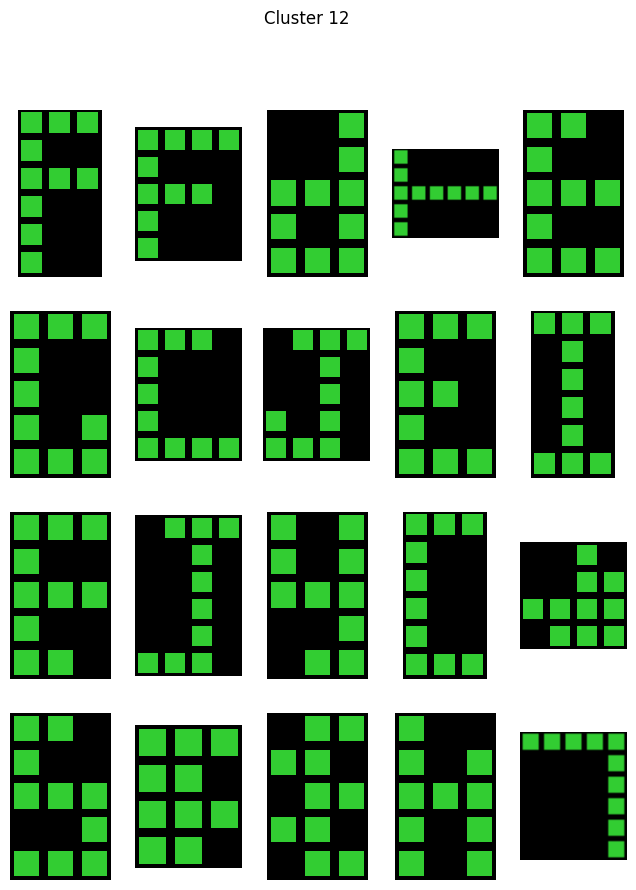

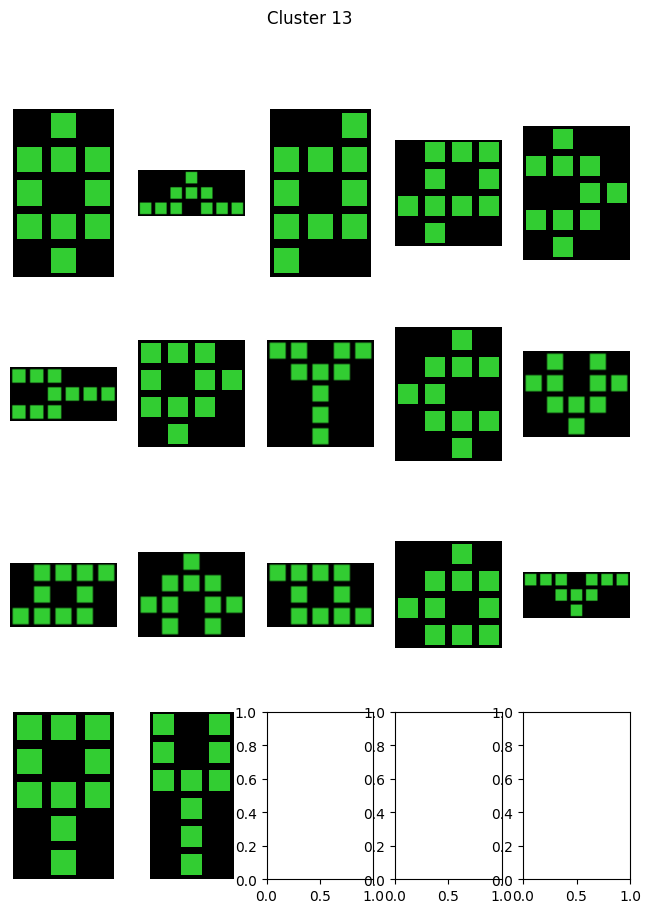

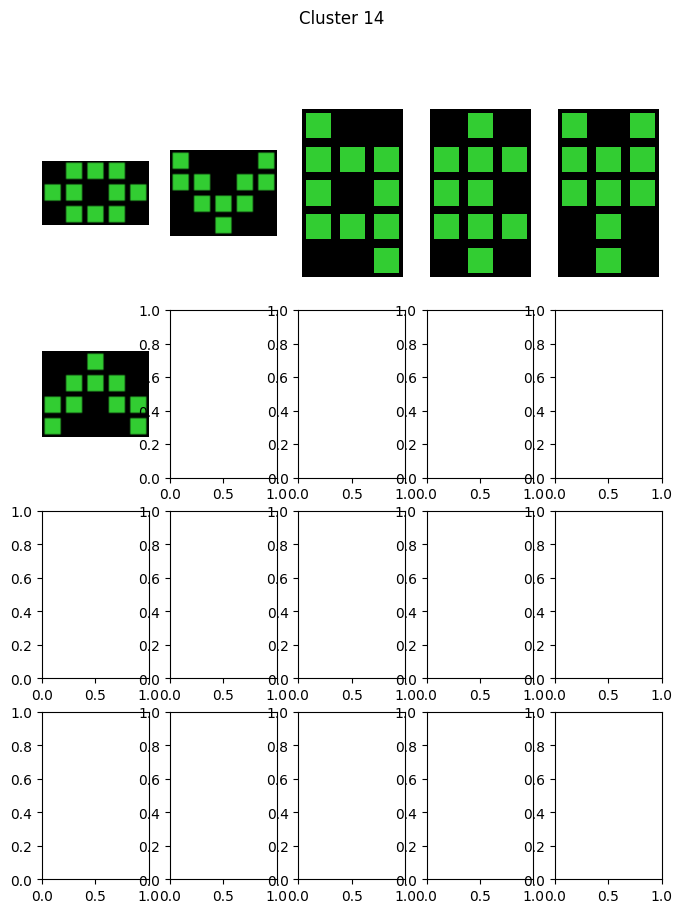

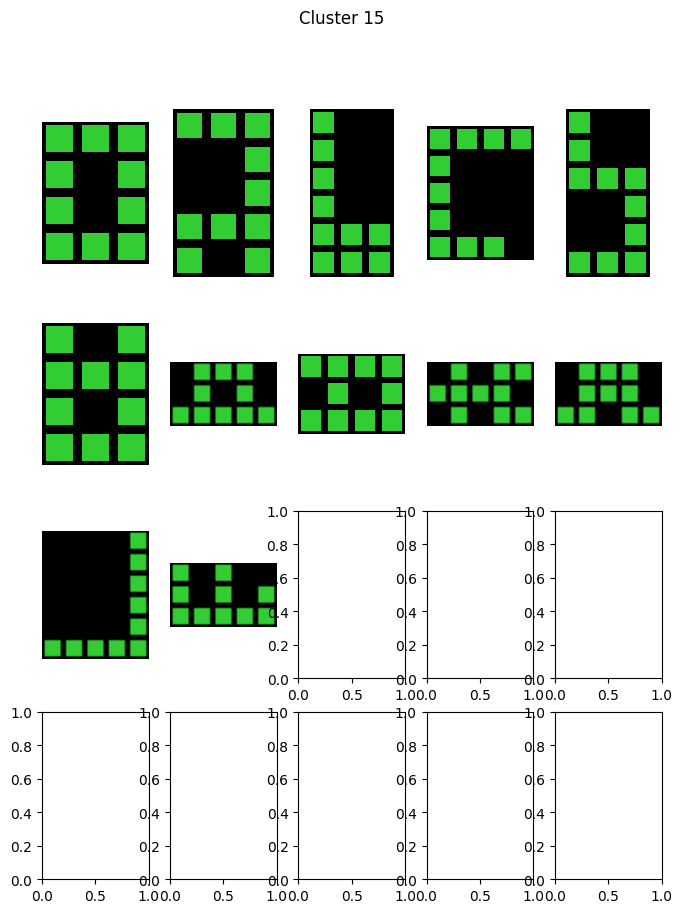

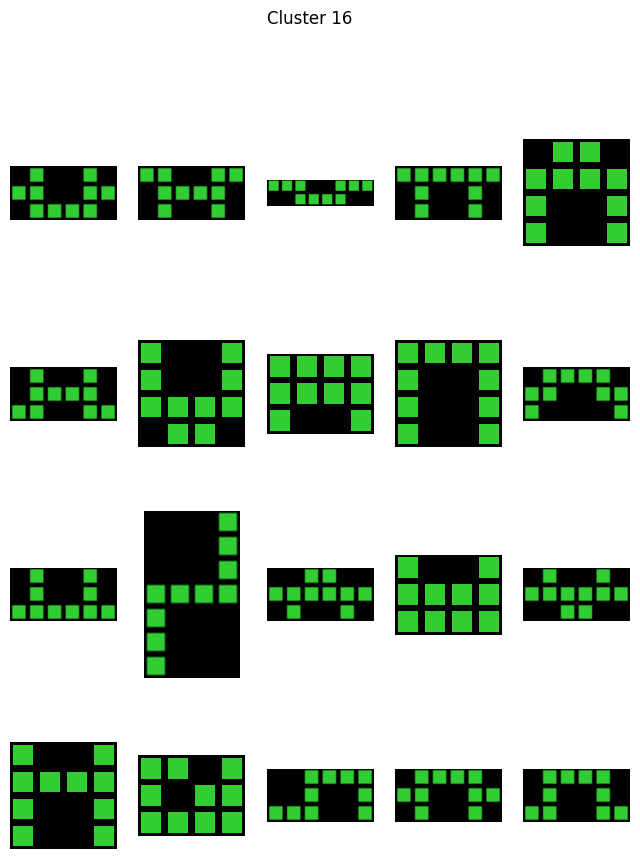

In [69]:
# plot the shapes in each of the clusters (with the highest silhouette score)
from sklearn.metrics import silhouette_samples
silhouette_values = silhouette_samples(transitions_projected_normed, kmeans.labels_)
cluster_df = pd.DataFrame({"cluster": kmeans.labels_, "silhouette": silhouette_values, "count": transition_matrix.sum(axis=1) / 2})
cluster_df = cluster_df.sort_values("silhouette", ascending=False)
for cluster in range(best_k):
    n = 20
    cluster_shapes = cluster_df[(cluster_df["cluster"] == cluster) & (cluster_df["count"] > 10)].index[:n]
    nh = int(np.sqrt(n))
    nv = int(np.ceil(n / nh))
    fig, axes = plt.subplots(nh, nv, figsize=(2 * nh, 2 * nv))
    axes_flat = axes.flatten()
    for shape_idx, ax in zip(cluster_shapes, axes_flat):
        ax.imshow(get_shape_image(idx2shape[shape_idx]))
        ax.axis("off")
    plt.suptitle(f"Cluster {cluster}")
    plt.show()

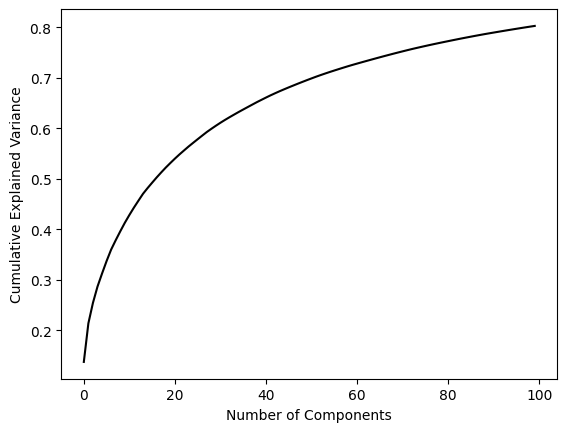

In [72]:
pca= PCA(n_components=min(transition_matrix.shape))
pca.fit(transition_matrix)
# plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:100], '-k')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [74]:
CHOSEN_DIM = 20
pca = PCA(n_components=CHOSEN_DIM)
pca.fit(transition_matrix)
transitions_projected_pca = pca.transform(transition_matrix)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=100, verbose=1)
shape_embeddings = tsne.fit_transform(transitions_projected_pca)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1190 samples in 0.001s...
[t-SNE] Computed neighbors for 1190 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1190
[t-SNE] Computed conditional probabilities for sample 1190 / 1190
[t-SNE] Mean sigma: 0.370329
[t-SNE] KL divergence after 50 iterations with early exaggeration: 54.402847
[t-SNE] KL divergence after 1000 iterations: 0.737247


In [77]:
# plot scatter of the points and show the image of the shape on hover
fig, ax = plt.subplots()
for shape_idx, (x, y) in enumerate(shape_embeddings):
    img = get_shape_image(idx2shape[shape_idx])
    imagebox = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import io
import base64

def numpy_to_base64_img(numpy_img):
    """
    Convert a numpy array representing an image (H x W x 3) to a base64-encoded PNG image string.
    :param numpy_img: A numpy array representing the image (H x W x 3).
    :return: A base64-encoded PNG image as a string.
    """
    # Convert the numpy array to a PIL image
    pil_img = Image.fromarray(numpy_img.astype('uint8'), 'RGB')

    # Save the image to a BytesIO object
    buffered = io.BytesIO()
    pil_img.save(buffered, format="PNG")

    # Encode the image as base64
    img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

    # Return the base64 string prefixed with the proper data URI scheme
    return f"data:image/png;base64,{img_base64}"

def generate_scatter_plot_with_images(points, images, output_html='scatter_with_images.html'):
    """
    Generates a scatter plot with images shown on hover.

    :param points: List of tuples representing 2D points [(x1, y1), (x2, y2), ...]
    :param images: List of numpy arrays representing images (each with shape H x W x 3)
    :param output_html: The filename for the generated HTML file (default is 'scatter_with_images.html').
    """
    # Unpack the points
    x_vals, y_vals = zip(*points)

    # Convert the numpy images to base64
    base64_images = [numpy_to_base64_img(img) for img in images]

    # Create the hover text, which includes an image HTML tag for each point
    hover_text = [
        f'<img src="{img_base64}" width="100" height="100"> <br>({x}, {y})'
        for x, y, img_base64 in zip(x_vals, y_vals, base64_images)
    ]

    # Create the scatter plot
    fig = go.Figure(data=go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='markers',
        hoverinfo='text',  # We use 'text' to specify custom hover behavior
        hovertext=hover_text,
        marker=dict(size=10, color='blue', line=dict(width=1, color='black'))
    ))

    # Set layout for better readability
    fig.update_layout(
        title="Scatter Plot with Images on Hover",
        xaxis_title="X",
        yaxis_title="Y",
        template="plotly_dark"  # optional: adjust the style of the plot
    )

    # Save to HTML file
    fig.write_html(output_html)
    print(f"HTML file saved as {output_html}")


Component 0
28309: 7.874674523121947
24910: 3.0142983559048235
423: 2.6163324196949356
13490: 2.135626247288724
20832: 1.885226363863969
8056: 1.3087584353702157
32126: 1.3067562536577848
17859: 1.1735753659117663
27904: 1.1709644521195457
16594: 1.087038766759318
13485: 1.041411808127241
2699: 0.9808242891425218
2345: 0.9321453871075226
8061: 0.918018046667244
27883: 0.9171668882349823
17947: 0.8623741004346915
16626: 0.837341416540014
8277: 0.7432695596429745
16549: 0.7399478659935917
16802: 0.7030842810973701


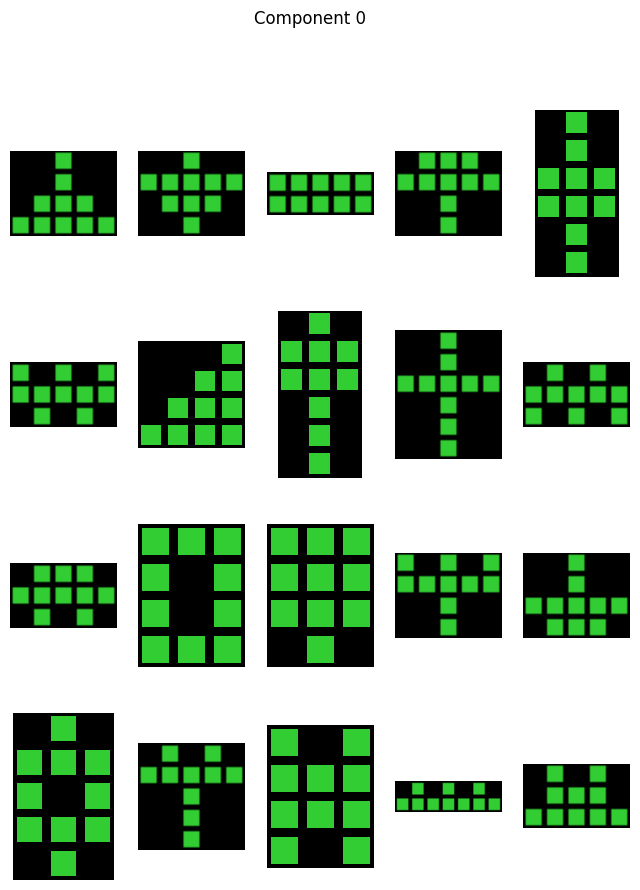

Component 1
2699: 4.663115634116207
2668: 3.409265396369251
2872: 2.4715814376341285
2669: 1.7874347086610012
8277: 1.738982937388058
12883: 1.6917782937878156
1378: 1.4245467126540814
8492: 1.3037518907189785
2356: 1.2973657176963638
2850: 1.214559148534357
851: 1.1926999428162914
3496: 1.1870729627203427
1291: 1.105322842442478
1361: 1.10333105929154
8505: 1.0626163391983996
8308: 0.9461563327397401
8891: 0.8945563566268563
2673: 0.8308598609519688
12907: 0.7824001766055981
13628: 0.7798148825321273


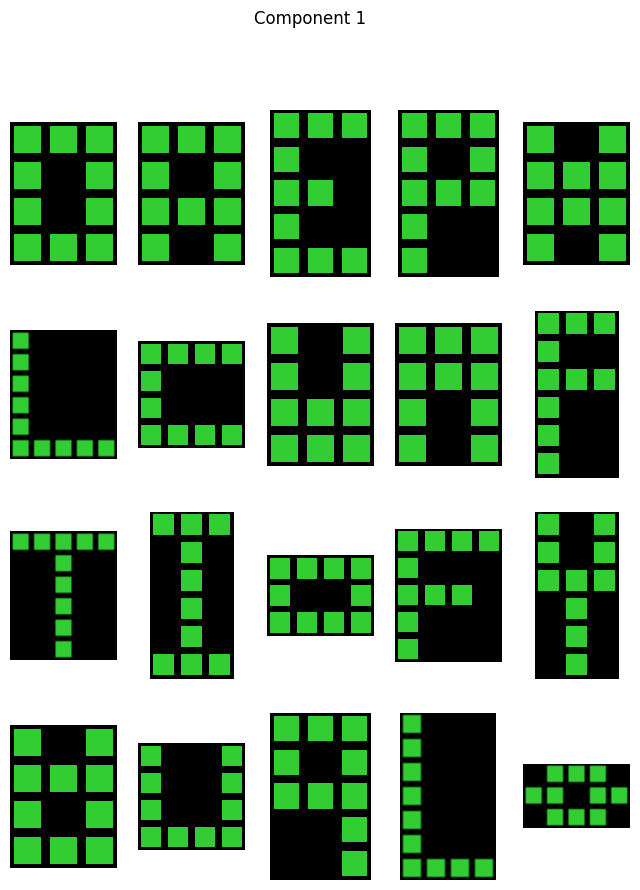

Component 2
5210: 2.7919388444450366
14492: 2.712907605704593
1291: 2.1098889760520803
1435: 1.9746592219888206
22911: 1.8582637623044431
15353: 1.7960067161672575
14534: 1.7589643655087532
10553: 1.7443904360730946
1038: 1.665173455273787
32126: 1.6304634623216627
8718: 1.5237208586905713
1448: 1.1899493643227481
15283: 1.1619312903981744
8891: 1.092972154418828
1036: 1.005983178401653
423: 1.00155594001049
13102: 0.8909577919420152
15281: 0.7931710696241323
14519: 0.782290719385817
1312: 0.7347053259179714


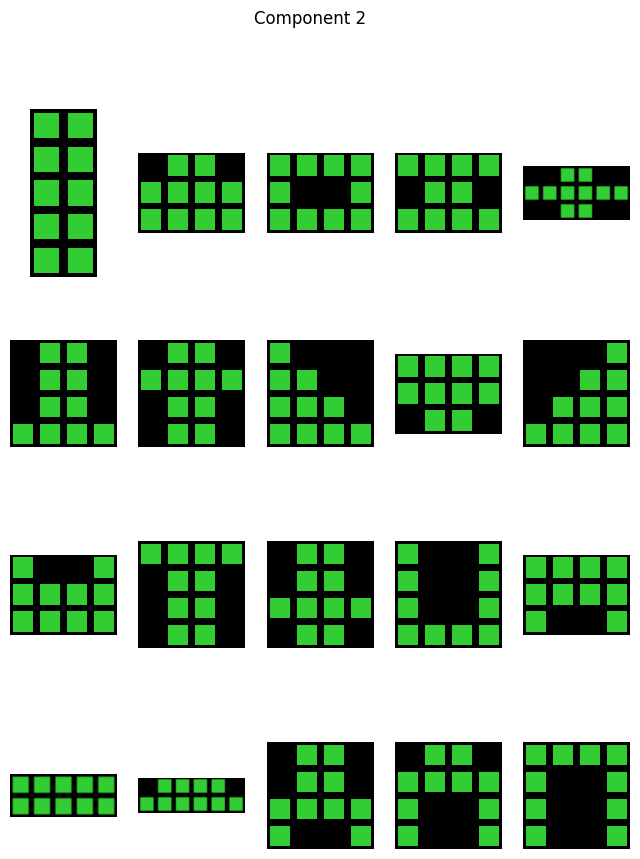

Component 3
17846: 5.811419825245724
2309: 2.3187483377196463
2346: 1.2712238888871505
1413: 1.2369831027969365
1045: 1.1933221255407658
17947: 1.0426996404353204
13507: 1.006257898194121
2344: 0.987062718965872
2343: 0.9513739398564476
32126: 0.9499992944415141
13869: 0.9175200061456845
8505: 0.5471159081158666
24910: 0.5460068280456202
1046: 0.5456099986984765
13628: 0.4573034834451639
10553: 0.4492126283491989
2383: 0.42442253105889477
18139: 0.41404011277098446
9789: 0.4011845097390726
8280: 0.39210961566288044


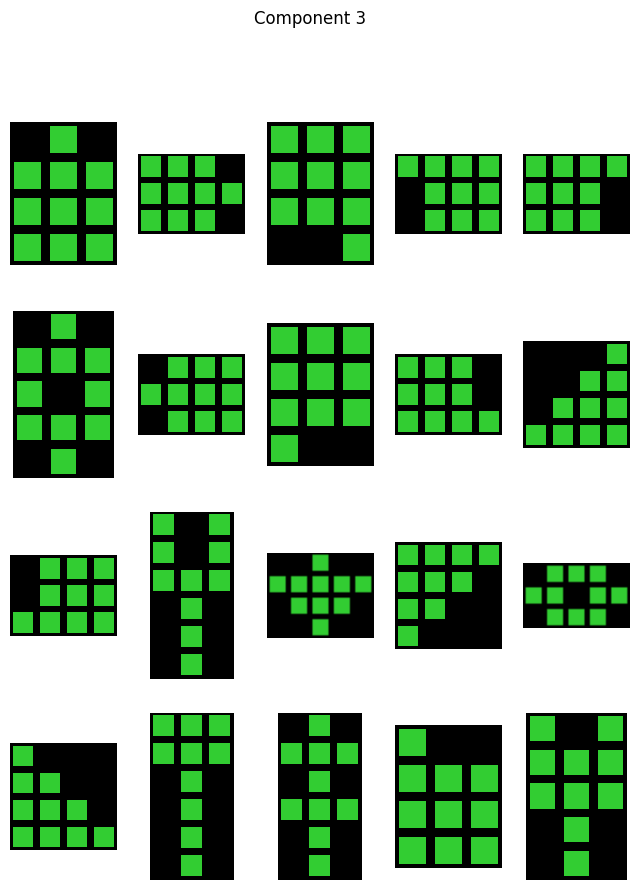

Component 4
26340: 4.9513810786388355
17846: 1.810359085627419
20832: 1.4370212720398534
617: 1.3376607759742205
27904: 1.0471245437988828
10553: 0.9170343021207832
24910: 0.8801508752939041
22315: 0.791852328562899
423: 0.7621057215457172
27883: 0.6536656769679898
28724: 0.5906447858602395
28233: 0.5713158003871106
17859: 0.563531966409203
851: 0.5626497891155008
33260: 0.5535880071779983
8277: 0.5046583896875929
24973: 0.4976215498054472
16594: 0.4902466358997955
8061: 0.4866983286384873
18136: 0.48385801696499925


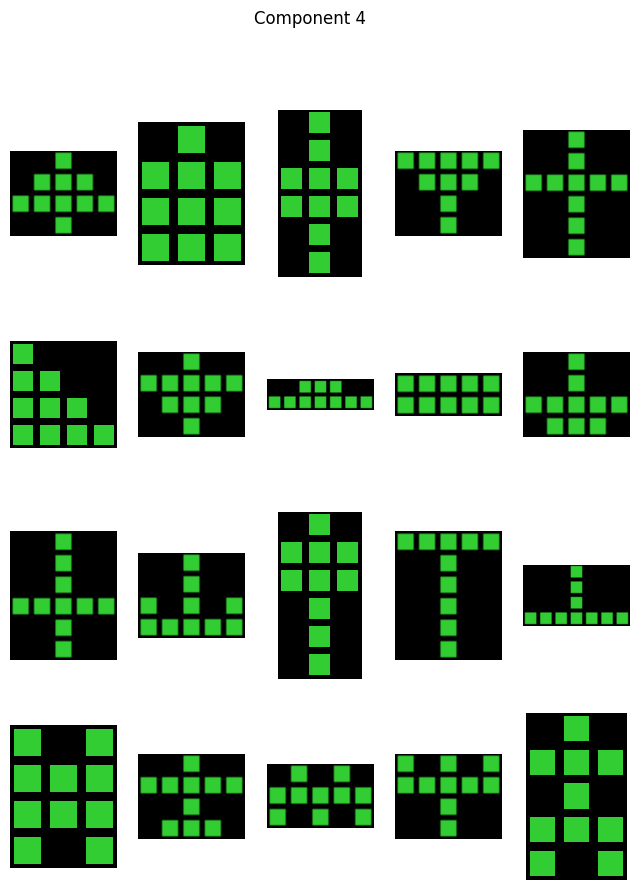

Component 5
1: 7.140685594035819
423: 2.0995452278436377
33931: 1.72395492396962
12919: 1.6982689177933008
22911: 1.5384903771654002
36446: 1.059712399278477
9108: 1.0284933406803711
2: 0.9837672915623376
10: 0.8209810128890238
9109: 0.8034001261095888
16549: 0.7794433284153568
9037: 0.7086218347626824
9071: 0.679499452288494
6: 0.6011346310241531
24738: 0.5664917588685832
16802: 0.556283378061674
30375: 0.5552502630431795
30405: 0.5211097992078797
35684: 0.5138804666540842
17166: 0.5130324901499358


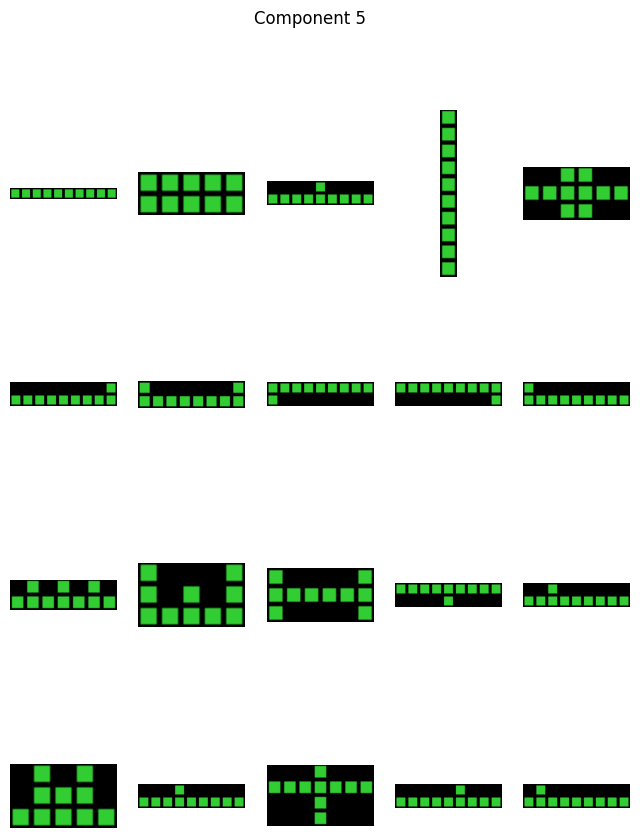

Component 6
2345: 5.268621571649876
13507: 1.793491701190632
25418: 1.7830510726702313
9789: 1.5086171826170485
2343: 1.347684061005489
2309: 1.3302695477842172
1045: 1.2057093118926296
20860: 0.8616334724118432
27904: 0.7604901570011633
20829: 0.7133676858358684
2699: 0.7038254868601828
10553: 0.6948986125042065
17859: 0.6477556135407724
21955: 0.6355084308402061
24973: 0.6341574097809693
28309: 0.6081264504805232
26551: 0.5919176388257376
20921: 0.5718653726397741
24910: 0.4986921924110651
32126: 0.4973591246336246


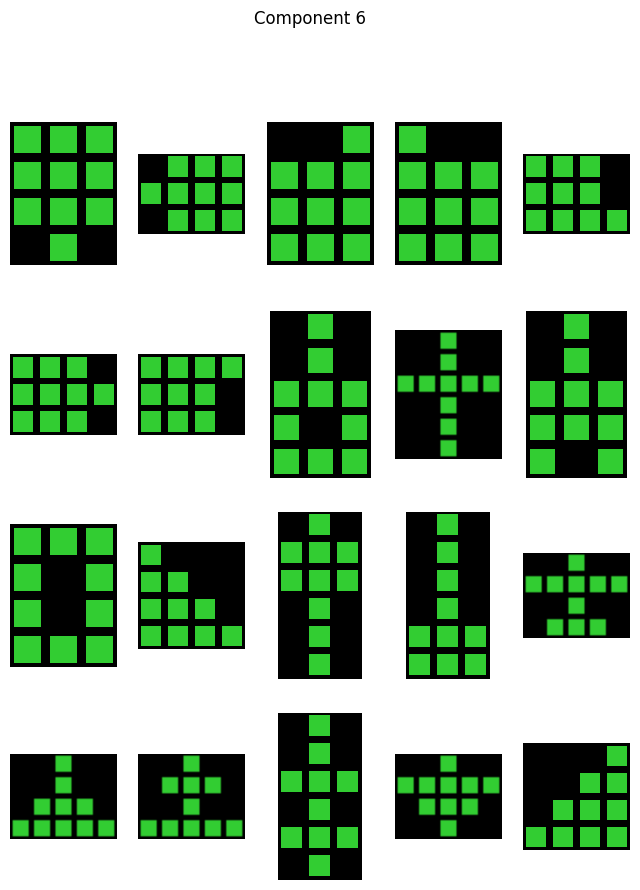

Component 7
12005: 3.9256038634489787
5657: 3.3544232598249017
2673: 2.840053293697538
2860: 2.2050306483665736
2669: 1.97992487822371
3985: 1.8900289334459706
8511: 1.8338122628552902
2668: 1.6052807338801875
2699: 1.1457540869361083
3878: 0.8303661364936225
851: 0.772958251918797
2872: 0.7700717747691646
28067: 0.7342980828902398
3942: 0.7020483788992599
2102: 0.584941570488139
3887: 0.5747335072344589
977: 0.5570811635963334
16145: 0.5374276453962064
2925: 0.4063392134049238
12883: 0.3830537641879487


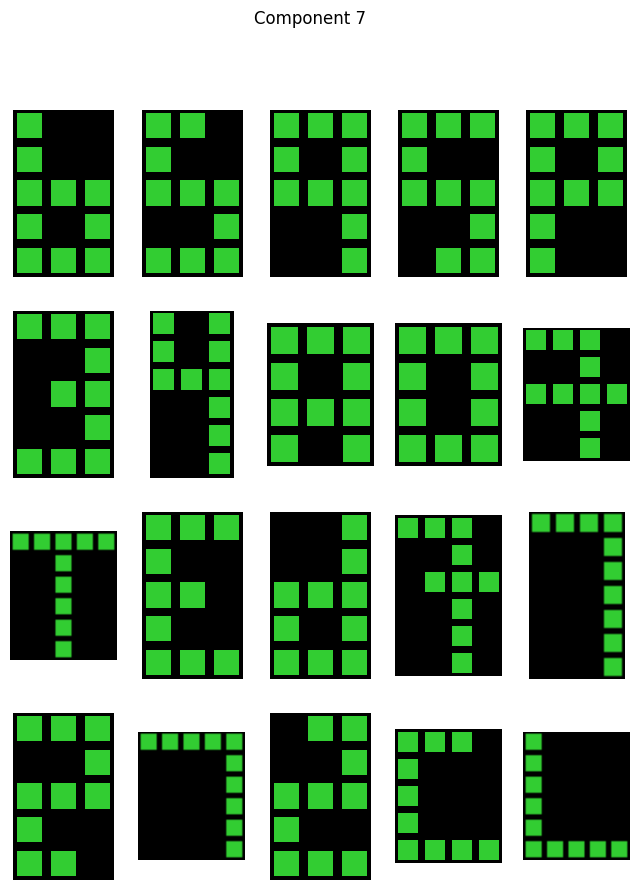

In [52]:
for i, comp in enumerate(nmf.components_):
    # plot the top n shapes in the component
    n = 20
    top_shapes = np.argsort(comp)[::-1][:n]
    print(f"Component {i}")
    nh = int(np.sqrt(n))
    nv = int(np.ceil(n / nh))
    fig, axes = plt.subplots(nh, nv, figsize=(2 * nh, 2 * nv))
    axes_flat = axes.flatten()
    for shape_idx, ax in zip(top_shapes, axes_flat):
        print(f"{idx2shape[shape_idx]}: {comp[shape_idx]}")
        ax.imshow(get_shape_image(idx2shape[shape_idx]))
        ax.axis("off")
    plt.suptitle("Component {}".format(i))
    plt.show()
    # plot the image of the shapes




In [ ]:
for i, comp in enumerate(nmf.components_ / nmf.components_.sum(axis=0, keepdims=True)):
    # plot the top n shapes in the component
    n = 20
    top_shapes = np.argsort(comp)[::-1][:n]
    print(f"Component {i}")
    nh = int(np.sqrt(n))
    nv = int(np.ceil(n / nh))
    fig, axes = plt.subplots(nh, nv, figsize=(2 * nh, 2 * nv))
    axes_flat = axes.flatten()
    for shape_idx, ax in zip(top_shapes, axes_flat):
        print(f"{idx2shape[shape_idx]}: {comp[shape_idx]}")
        ax.imshow(get_shape_image(idx2shape[shape_idx]))
        ax.axis("off")
    plt.suptitle("Component {}".format(i))
    plt.show()

/var/folders/ln/fz914crs0q5dckkmx9pkp55h0000gn/T/ipykernel_26008/1709782778.py:2: RuntimeWarning: divide by zero encountered in log
  comp_prob_entropy = -np.sum(comp_prob * np.where(comp_prob > 0 , np.log(comp_prob), 0), axis=0)


Top entropy shapes
6473: 1.8231393979685635
6473: [0.         0.09192092 0.13546247 0.10974165 0.0799767  0.1742712
 0.01517813 0.10506689]
7790: 1.7994570998447816
7790: [0.0446928  0.01375151 0.01842952 0.0117246  0.01032682 0.03106236
 0.01352789 0.        ]
614: 1.762027214208648
614: [0.18833011 0.17718457 0.         0.11450403 0.14707177 0.18854382
 0.06664655 0.00410155]
19074: 1.7554992873875634
19074: [0.13734113 0.10755974 0.01796395 0.0860099  0.16270459 0.02738056
 0.0600311  0.        ]
4646: 1.7540844899483057
4646: [0.00557469 0.01292657 0.01302632 0.0061279  0.00179129 0.01791714
 0.00456448 0.        ]
1549: 1.7538326298614064
1549: [0.01160109 0.00718917 0.02622613 0.01172946 0.00301475 0.
 0.01934653 0.00558864]
8043: 1.7429495325257034
8043: [0.10706349 0.06286838 0.06450937 0.08538413 0.03566675 0.07921905
 0.         0.        ]
20046: 1.7122312413028609
20046: [0.01631011 0.02718158 0.01125353 0.00355566 0.0561424  0.05141542
 0.02763684 0.        ]
8474: 1.70810

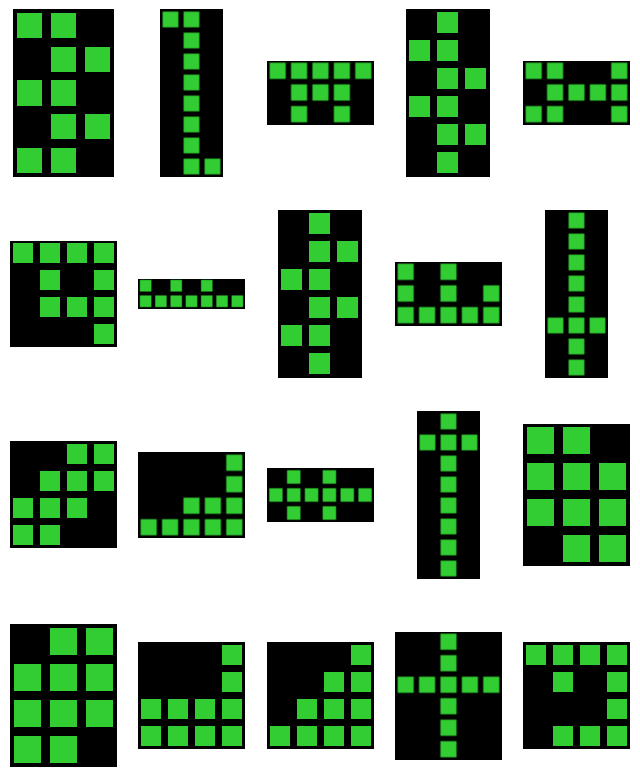

In [22]:
comp_prob = nmf.components_ / nmf.components_.sum(axis=0, keepdims=True)
comp_prob_entropy = -np.sum(comp_prob * np.where(comp_prob > 0 , np.log(comp_prob), 0), axis=0)
# plot the min entropy shapes:
n = 20
shapes_order = np.argsort(comp_prob_entropy)
top_shapes = shapes_order[transition_matrix[shapes_order,:].sum(axis=1) > 10][::-1][:n]
print(f"Top entropy shapes")
nh = int(np.sqrt(n))
nv = int(np.ceil(n / nh))
fig, axes = plt.subplots(nh, nv, figsize=(2 * nh, 2 * nv))
axes_flat = axes.flatten()
for shape_idx, ax in zip(top_shapes, axes_flat):
    print(f"{idx2shape[shape_idx]}: {comp_prob_entropy[shape_idx]}")
    print(f"{idx2shape[shape_idx]}: {nmf.components_[:, shape_idx]}")
    ax.imshow(get_shape_image(idx2shape[shape_idx]))
    ax.axis("off")

Top meaning shapes
17846: [0.07594008 0.18192906 0.05663092 5.81141983 1.81035909 0.45380542
 0.         0.        ]


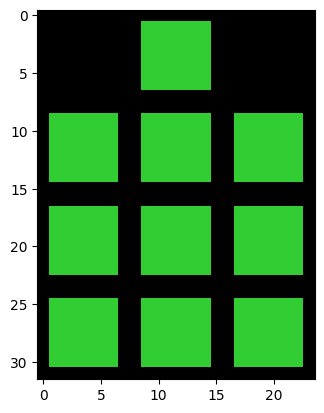

423: [2.61633242 0.41278165 1.00155594 0.05862209 0.76210572 2.09954523
 0.11349296 0.        ]


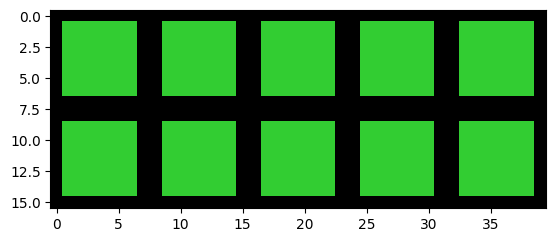

2309: [0.         0.         0.02997018 2.31874834 0.         0.01714632
 1.33026955 0.        ]


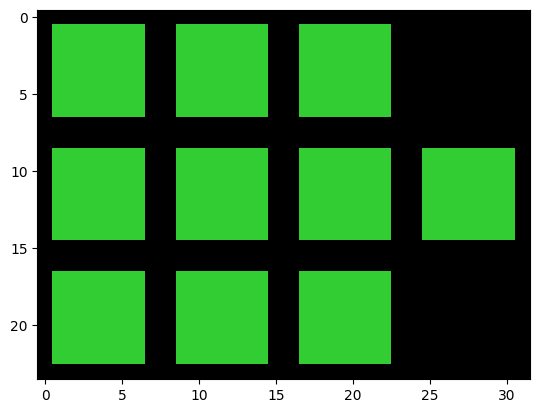

2669: [0.         1.78743471 0.         0.         0.         0.16637885
 0.         1.97992488]


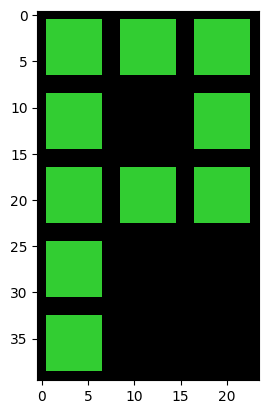

22911: [0.1320069  0.         1.85826376 0.04531481 0.         1.53849038
 0.1664704  0.        ]


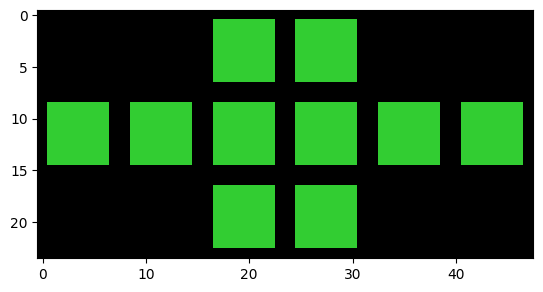

20832: [1.88522636 0.         0.         0.30852411 1.43702127 0.
 0.13248155 0.05041599]


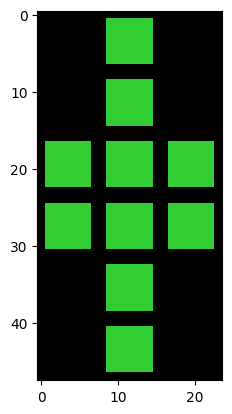

In [53]:
two_cat = np.sum(nmf.components_ > np.quantile(nmf.components_, 0.995, axis=1, keepdims=True), axis=0) >= 2
meaning_magnitude = np.sum(nmf.components_ ** 2, axis=0)
shapes_order = np.argsort(meaning_magnitude)
top_shapes = shapes_order[two_cat[shapes_order]][::-1][:n]

print(f"Top meaning shapes")
nh = int(np.sqrt(n))
nv = int(np.ceil(n / nh))
# fig, axes = plt.subplots(nh, nv, figsize=(2 * nh, 2 * nv))
axes_flat = axes.flatten()
for shape_idx, ax in zip(top_shapes, axes_flat):
    print(f"{idx2shape[shape_idx]}: {nmf.components_[:, shape_idx]}")
    plt.imshow(get_shape_image(idx2shape[shape_idx]))
    plt.show()
    # ax.imshow(get_shape_image(idx2shape[shape_idx]))
    # ax.axis("off")

plt.show()

In [38]:
print(transition_matrix[np.argmax(transition_matrix[transition_matrix.sum(axis=0) == 2], axis=1)].shape)
print(transition_matrix[transition_matrix.sum(axis=0) == 2].shape)

(4783, 7854)
(4783, 7854)


In [42]:
(transition_matrix[np.argmax(transition_matrix[transition_matrix.sum(axis=0) == 2], axis=1)].sum(axis=1) == 2).mean()

np.float64(0.34915325109763745)

In [44]:
transition_matrix[transition_matrix.sum(axis=0) == 2].sum()/ transition_matrix.sum()

np.float64(0.1647038567493113)